In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import os
import cPickle as cp
import sys
sys.path.append("../../utils/")
from plot_utils import get_colors

In [2]:
def get_value_from_dict(folder_name, key=None):
    with open(folder_name + "/results.pkl") as f:
        res_dict = cp.load(f)
    return res_dict[key]

In [3]:
colors_dict = get_colors()

# kernel approximation error

In [4]:
# F norm squared
F_norm_exact_kernel = 214056425.583
F_norm_fp_rff_1024 = 217285107.943
def get_kernel_approx_error(subkey_list, result_folder):
    kernel_approx_error_list = []
    subdirs = [x[0] for x in os.walk(result_folder)] 
#     test_list = []
#     print subdirs
    for subdir in subdirs:
#         print subdir
        is_target = True
        for subkey in subkey_list:
            if subkey not in subdir:
                is_target = False
                break
        if is_target:
#             test_list.append(subdir)  
#             assert "pca" not in subdir
#             print "in target"
            if "_pca_rff_mu" in subdir:
                if "/results.pkl" in subdir and os.path.isdir(subdir):
                    kernel_approx_error_list.append(\
                        np.sqrt(get_value_from_dict(subdir, "train_approx_error") / F_norm_fp_rff_1024) )
            else:
                kernel_approx_error_list.append(\
                    np.sqrt(get_value_from_dict(subdir, "train_approx_error") / F_norm_fp_rff_1024) )
#     print len(kernel_approx_error_list)
#     test_list = sorted(test_list)
#     for test in test_list:
#         print test
    return kernel_approx_error_list 

In [5]:
general_folder = "/Users/Jian/Data/research/lp_kernel/lp_kernel/kernel_reg/multi_seed_results/census_results_64_bit_pca_rff/"

In [6]:
general_folder_old = "/Users/Jian/Data/research/lp_kernel/lp_kernel/kernel_reg/multi_seed_results/census_results_64_bit/"

In [19]:
with open(general_folder + "lambda_1e-3_seed_1_n_fp_feat_1024_lp_pca_rff_mu_10.0_n_base_feat_1024/results.pkl/results.pkl", "r") as f:
    test = cp.load(f)
print test

{'train_approx_error': 49399.75806779626, 'train_l2_error': 18983031.599290162, 'test_approx_error': 5539.045818835388, 'test_l2_error': 44462943.83528177}


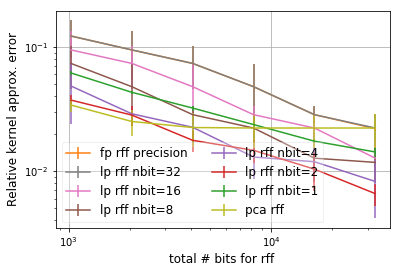

In [7]:
# plot for fixed number of features
fp_bits = 32
plt.figure()
# n_feat_list = [32, 64, 128, 256, 512, 1024, 2048, 4096, 8192]
n_feat_list = [32, 64, 128, 256, 512, 1024]
# plot full precision kernel approximation
mean_error = []
std_error = []
for n_feat in n_feat_list:
    subkey_list = ["_fp_rff", "n_fp_feat_" + str(n_feat) ]
    fp_approx_error = get_kernel_approx_error(subkey_list, general_folder)
    mean_error.append(np.mean(fp_approx_error) )
    std_error.append(np.std(fp_approx_error) )
#     print len(fp_approx_error)
plt.errorbar(np.array(n_feat_list) * fp_bits, mean_error, color=colors_dict["fp"], yerr=std_error, label="fp rff precision")

# note the error bar need to be replotted due to different number of samples
for n_bit in [32, 16, 8, 4, 2, 1]:
    mean_error = []
    std_error = []
    for n_feat in n_feat_list:
        subkey_list = ["_lp_rff", "n_fp_feat_" + str(n_feat), "nbit_" + str(n_bit) + "_" ]
        fp_approx_error = get_kernel_approx_error(subkey_list, general_folder)
        mean_error.append(np.mean(fp_approx_error) )
        std_error.append(np.std(fp_approx_error) )
#         print len(fp_approx_error) 
    plt.errorbar(np.array(n_feat_list) * fp_bits, mean_error, color=colors_dict[str(n_bit)], yerr=std_error, label="lp rff nbit="+str(n_bit) )
#     print mean_error

# note the error bar need to be replotted due to different number of samples
mean_error = []
std_error = []
for n_feat in n_feat_list:
    mean_error_tmp = []
    std_error_tmp = []
    for mu in [1.0, 2.0, 5.0, 10.0, 20.0, 50.0]:
        subkey_list = ["_lp_pca_rff", "_mu_" + str(mu) + "_", "n_fp_feat_" + str(n_feat), "n_base_feat_1024"]
        fp_approx_error = get_kernel_approx_error(subkey_list, general_folder)
        mean_error_tmp.append(np.mean(fp_approx_error) )
        std_error_tmp.append(np.std(fp_approx_error) )
#         print len(fp_approx_error) 
    mean_error.append(np.min(mean_error_tmp) )
    std_error.append(std_error_tmp[np.argmin(mean_error_tmp) ] )
        
plt.errorbar(np.array(n_feat_list) * fp_bits, mean_error, color=colors_dict["pca"], yerr=std_error, label="pca rff" )
#     print mean_error

    
ax = plt.subplot(111)
ax.set_xscale("log")
ax.set_yscale("log")
plt.grid()
# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5) )
plt.legend(ncol=2, fontsize=12, framealpha=0.3)
plt.xlabel("total # bits for rff ", fontsize=12)
plt.ylabel("Relative kernel approx. error", fontsize=12)
# plt.ylabel("Relative kernel approx. error (based on F-norm)")
# plt.xlim([n_feat_list[0] * 0.9 * fp_bits, n_feat_list[-1] * 1.1 * fp_bits])
# plt.ylim([1e-3, 5e-2])
# plt.savefig("../../notes/figures/kernel_approx_error.pdf", bbox_inches='tight')
plt.show()

# Train and test l2 loss

In [8]:
def get_l2_error(subkey_list, result_folder):
    l2_error_train_list = []
    l2_error_test_list = []
    lambda_list = []
    subdirs = [x[0] for x in os.walk(result_folder)] 
    for subdir in subdirs:
        is_target = True
        for subkey in subkey_list:
            if subkey not in subdir:
                is_target = False
                break
        if is_target:
            if "_pca_rff_mu" in subdir:
                if ("/results.pkl" not in subdir) or (not os.path.isdir(subdir) ):
                    continue
#             print subdir
#             raw_input()
            l2_error_train_list.append(np.sqrt(get_value_from_dict(subdir, "train_l2_error") ) )
            l2_error_test_list.append(np.sqrt(get_value_from_dict(subdir, "test_l2_error") ) )
            lambda_list.append(float(subdir.split("lambda_")[1].split("_")[0]) )
    return l2_error_train_list, l2_error_test_list, lambda_list

### plot l2 loss  with best lambda for different 

### only the low precision train/test results

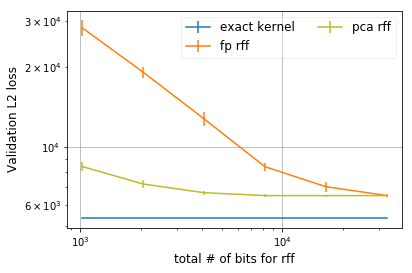

In [9]:
# plot for fixed number of features
def get_perf_for_one_precision(subkey_list_input, general_folder):
    fp_bits = 32
    lamb_list = ["1e-6", "1e-5", "1e-4", "1e-3", "1e-2", "1e-1", "1e0", "1e1", "1e2"]
    lamb_list_num = [float(x) for x in lamb_list]
    l2_train_mean = []
    l2_train_std = []
    l2_test_mean = []
    l2_test_std = []
    for lamb in lamb_list:
        subkey_list = subkey_list_input + ["lambda_" + lamb + "_"]
        l2_train, l2_test, lambda_list  = get_l2_error(subkey_list, general_folder)
        l2_train_mean.append(np.mean(l2_train) ) 
        l2_train_std.append(np.std(l2_train) )
        l2_test_mean.append(np.mean(l2_test) )
        l2_test_std.append(np.std(l2_test) )
    return l2_train_mean, l2_train_std, l2_test_mean, l2_test_std,
    
# training l2
plt.figure()
nbit_list = [32, 16, 8, 4, 2, 1]
# nbit_list = [2,]
fp_bits = 32
    

# test l2
plt.figure()
nbit_list = [32, 16, 8, 4, 2, 1]
n_feat_list = [32, 64, 128, 256, 512, 1024]

# exact kernel
train_mean_list = []
test_mean_list = []
train_std_list = []
test_std_list = []
subkey_list_input = ["exact", ]
train_mean, train_std, test_mean, test_std = get_perf_for_one_precision(subkey_list_input, general_folder)
test_mean_list.append(np.min(test_mean) )
train_mean_list.append(train_mean[np.argmin(test_mean) ] )
test_std_list.append(test_std[np.argmin(test_mean) ] )
train_std_list.append(train_std[np.argmin(test_mean) ] )
plt.errorbar(np.array(n_feat_list) * fp_bits, test_mean_list * len(n_feat_list), color=colors_dict["exact"], fmt="-", yerr=test_std_list * len(n_feat_list), label="exact kernel")

# fp results
train_mean_list = []
test_mean_list = []
train_std_list = []
test_std_list = []
for n_feat in n_feat_list:
    subkey_list_input = ["fp_rff", "n_fp_feat_" + str(n_feat) ]
    train_mean, train_std, test_mean, test_std = get_perf_for_one_precision(subkey_list_input, general_folder_old)
    test_mean_list.append(np.min(test_mean) )
    train_mean_list.append(train_mean[np.argmin(test_mean) ] )
    test_std_list.append(test_std[np.argmin(test_mean) ] )
    train_std_list.append(train_std[np.argmin(test_mean) ] )
plt.errorbar(np.array(n_feat_list) * fp_bits, test_mean_list, color=colors_dict["fp"], fmt="-", yerr=test_std_list, label="fp rff")

# for nbit in nbit_list:
#     train_mean_list = []
#     test_mean_list = []
#     train_std_list = []
#     test_std_list = []
#     for n_feat in n_feat_list:
# #         print "nbit ", nbit, "n_feat", n_feat
#         subkey_list_input = ["lp_rff", "nbit_" + str(nbit) + "_", "n_fp_feat_" + str(n_feat) ]
#         train_mean, train_std, test_mean, test_std = get_perf_for_one_precision(subkey_list_input, general_folder)
#         test_mean_list.append(np.min(test_mean) )
#         train_mean_list.append(train_mean[np.argmin(test_mean) ] )
#         test_std_list.append(test_std[np.argmin(test_mean) ] )
#         train_std_list.append(train_std[np.argmin(test_mean) ] )
#     plt.errorbar(np.array(n_feat_list) * fp_bits, test_mean_list, fmt="-", yerr=test_std_list, label="var reduce nbit " + str(nbit) )

# for nbit in nbit_list:
#     train_mean_list = []
#     test_mean_list = []
#     train_std_list = []
#     test_std_list = []
#     for n_feat in n_feat_list:
# #         print "nbit ", nbit, "n_feat", n_feat
#         subkey_list_input = ["lp_rff", "nbit_" + str(nbit) + "_", "n_fp_feat_" + str(n_feat) ]
#         train_mean, train_std, test_mean, test_std = get_perf_for_one_precision(subkey_list_input, general_folder)
#         test_mean_list.append(np.min(test_mean) )
#         train_mean_list.append(train_mean[np.argmin(test_mean) ] )
#         test_std_list.append(test_std[np.argmin(test_mean) ] )
#         train_std_list.append(train_std[np.argmin(test_mean) ] )
#     plt.errorbar(np.array(n_feat_list) * fp_bits, test_mean_list, color=colors_dict[str(nbit)], fmt="-", yerr=test_std_list, label="nbit " + str(nbit) )    
    
    
# note the error bar need to be replotted due to different number of samples
train_mean_list = []
test_mean_list = []
train_std_list = []
test_std_list = []
for n_feat in n_feat_list:
    train_mean_list_tmp = []
    test_mean_list_tmp = []
    train_std_list_tmp = []
    test_std_list_tmp = []
    for mu in [1.0, 2.0, 5.0, 10.0, 20.0, 50.0]:
        subkey_list_input = ["_lp_pca_rff", "_mu_" + str(mu) + "_", "n_fp_feat_" + str(n_feat), "n_base_feat_1024"]
        train_mean, train_std, test_mean, test_std = get_perf_for_one_precision(subkey_list_input, general_folder)
#         print train_mean, train_std, test_mean, test_std
#         print np.nanmin(test_mean)
        test_mean_list_tmp.append(np.nanmin(test_mean) )
        train_mean_list_tmp.append(train_mean[np.nanargmin(test_mean) ] )
        test_std_list_tmp.append(test_std[np.nanargmin(test_mean) ] )
        train_std_list_tmp.append(train_std[np.nanargmin(test_mean) ] )
        
    train_mean_list.append(train_mean_list_tmp[np.argmin(test_mean_list_tmp)] )
    test_mean_list.append(np.min(test_mean_list_tmp) )
    train_std_list.append(train_std_list_tmp[np.argmin(test_mean_list_tmp) ] )
    test_std_list.append(test_std_list_tmp[np.argmin(test_mean_list_tmp) ] )
        
plt.errorbar(np.array(n_feat_list) * fp_bits, test_mean_list, color=colors_dict["pca"], fmt="-", yerr=test_std_list, label="pca rff")    

    
ax = plt.subplot(111)
# plt.title("Test l2 loss")
ax.set_xscale("log")
ax.set_yscale("log")
plt.legend(ncol=2, fontsize=12, framealpha=0.3)
plt.ylabel("Validation L2 loss", fontsize=12)
plt.xlabel("total # of bits for rff", fontsize=12)
plt.grid()
# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# plt.savefig("../../notes/figures/valid_l2.pdf", bbox_inches='tight')
plt.show()

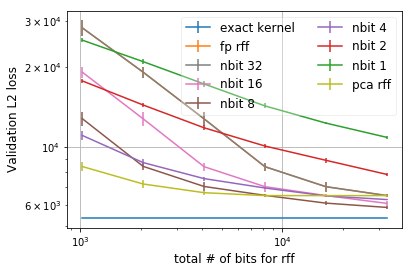

In [10]:
# plot for fixed number of features
def get_perf_for_one_precision(subkey_list_input, general_folder):
    fp_bits = 32
    lamb_list = ["1e-6", "1e-5", "1e-4", "1e-3", "1e-2", "1e-1", "1e0", "1e1", "1e2"]
    lamb_list_num = [float(x) for x in lamb_list]
    l2_train_mean = []
    l2_train_std = []
    l2_test_mean = []
    l2_test_std = []
    for lamb in lamb_list:
        subkey_list = subkey_list_input + ["lambda_" + lamb + "_"]
        l2_train, l2_test, lambda_list  = get_l2_error(subkey_list, general_folder)
        l2_train_mean.append(np.mean(l2_train) ) 
        l2_train_std.append(np.std(l2_train) )
        l2_test_mean.append(np.mean(l2_test) )
        l2_test_std.append(np.std(l2_test) )
    return l2_train_mean, l2_train_std, l2_test_mean, l2_test_std,
    
# training l2
plt.figure()
nbit_list = [32, 16, 8, 4, 2, 1]
# nbit_list = [2,]
fp_bits = 32
    

# test l2
plt.figure()
nbit_list = [32, 16, 8, 4, 2, 1]
n_feat_list = [32, 64, 128, 256, 512, 1024]

# exact kernel
train_mean_list = []
test_mean_list = []
train_std_list = []
test_std_list = []
subkey_list_input = ["exact", ]
train_mean, train_std, test_mean, test_std = get_perf_for_one_precision(subkey_list_input, general_folder)
test_mean_list.append(np.min(test_mean) )
train_mean_list.append(train_mean[np.argmin(test_mean) ] )
test_std_list.append(test_std[np.argmin(test_mean) ] )
train_std_list.append(train_std[np.argmin(test_mean) ] )
plt.errorbar(np.array(n_feat_list) * fp_bits, test_mean_list * len(n_feat_list), color=colors_dict["exact"], fmt="-", yerr=test_std_list * len(n_feat_list), label="exact kernel")

# fp results
train_mean_list = []
test_mean_list = []
train_std_list = []
test_std_list = []
for n_feat in n_feat_list:
    subkey_list_input = ["fp_rff", "n_fp_feat_" + str(n_feat) ]
    train_mean, train_std, test_mean, test_std = get_perf_for_one_precision(subkey_list_input, general_folder)
    test_mean_list.append(np.min(test_mean) )
    train_mean_list.append(train_mean[np.argmin(test_mean) ] )
    test_std_list.append(test_std[np.argmin(test_mean) ] )
    train_std_list.append(train_std[np.argmin(test_mean) ] )
plt.errorbar(np.array(n_feat_list) * fp_bits, test_mean_list, color=colors_dict["fp"], fmt="-", yerr=test_std_list, label="fp rff")

# for nbit in nbit_list:
#     train_mean_list = []
#     test_mean_list = []
#     train_std_list = []
#     test_std_list = []
#     for n_feat in n_feat_list:
# #         print "nbit ", nbit, "n_feat", n_feat
#         subkey_list_input = ["lp_rff", "nbit_" + str(nbit) + "_", "n_fp_feat_" + str(n_feat) ]
#         train_mean, train_std, test_mean, test_std = get_perf_for_one_precision(subkey_list_input, general_folder)
#         test_mean_list.append(np.min(test_mean) )
#         train_mean_list.append(train_mean[np.argmin(test_mean) ] )
#         test_std_list.append(test_std[np.argmin(test_mean) ] )
#         train_std_list.append(train_std[np.argmin(test_mean) ] )
#     plt.errorbar(np.array(n_feat_list) * fp_bits, test_mean_list, fmt="-", yerr=test_std_list, label="var reduce nbit " + str(nbit) )

for nbit in nbit_list:
    train_mean_list = []
    test_mean_list = []
    train_std_list = []
    test_std_list = []
    for n_feat in n_feat_list:
#         print "nbit ", nbit, "n_feat", n_feat
        subkey_list_input = ["lp_rff", "nbit_" + str(nbit) + "_", "n_fp_feat_" + str(n_feat) ]
        train_mean, train_std, test_mean, test_std = get_perf_for_one_precision(subkey_list_input, general_folder)
        test_mean_list.append(np.min(test_mean) )
        train_mean_list.append(train_mean[np.argmin(test_mean) ] )
        test_std_list.append(test_std[np.argmin(test_mean) ] )
        train_std_list.append(train_std[np.argmin(test_mean) ] )
    plt.errorbar(np.array(n_feat_list) * fp_bits, test_mean_list, color=colors_dict[str(nbit)], fmt="-", yerr=test_std_list, label="nbit " + str(nbit) )    
    
    
# note the error bar need to be replotted due to different number of samples
train_mean_list = []
test_mean_list = []
train_std_list = []
test_std_list = []
for n_feat in n_feat_list:
    train_mean_list_tmp = []
    test_mean_list_tmp = []
    train_std_list_tmp = []
    test_std_list_tmp = []
    for mu in [1.0, 2.0, 5.0, 10.0, 20.0, 50.0]:
        subkey_list_input = ["_lp_pca_rff", "_mu_" + str(mu) + "_", "n_fp_feat_" + str(n_feat), "n_base_feat_1024"]
        train_mean, train_std, test_mean, test_std = get_perf_for_one_precision(subkey_list_input, general_folder)
#         print train_mean, train_std, test_mean, test_std
#         print np.nanmin(test_mean)
        test_mean_list_tmp.append(np.nanmin(test_mean) )
        train_mean_list_tmp.append(train_mean[np.nanargmin(test_mean) ] )
        test_std_list_tmp.append(test_std[np.nanargmin(test_mean) ] )
        train_std_list_tmp.append(train_std[np.nanargmin(test_mean) ] )
        
    train_mean_list.append(train_mean_list_tmp[np.argmin(test_mean_list_tmp)] )
    test_mean_list.append(np.min(test_mean_list_tmp) )
    train_std_list.append(train_std_list_tmp[np.argmin(test_mean_list_tmp) ] )
    test_std_list.append(test_std_list_tmp[np.argmin(test_mean_list_tmp) ] )
        
plt.errorbar(np.array(n_feat_list) * fp_bits, test_mean_list, color=colors_dict["pca"], fmt="-", yerr=test_std_list, label="pca rff")    

    
ax = plt.subplot(111)
# plt.title("Test l2 loss")
ax.set_xscale("log")
ax.set_yscale("log")
plt.legend(ncol=2, fontsize=12, framealpha=0.3)
plt.ylabel("Validation L2 loss", fontsize=12)
plt.xlabel("total # of bits for rff", fontsize=12)
plt.grid()
# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# plt.savefig("../../notes/figures/valid_l2.pdf", bbox_inches='tight')
plt.show()

### plot also the variance reduction results

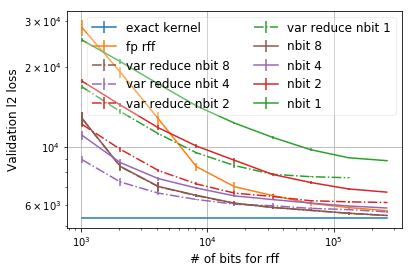

In [40]:
# plot for fixed number of features
def get_perf_for_one_precision(subkey_list_input, general_folder):
    fp_bits = 32
    lamb_list = ["1e-6", "1e-5", "1e-4", "1e-3", "1e-2", "1e-1", "1e0", "1e1", "1e2"]
    lamb_list_num = [float(x) for x in lamb_list]
    l2_train_mean = []
    l2_train_std = []
    l2_test_mean = []
    l2_test_std = []
    for lamb in lamb_list:
        subkey_list = subkey_list_input + ["lambda_" + lamb + "_"]
        l2_train, l2_test, lambda_list  = get_l2_error(subkey_list, general_folder)
        l2_train_mean.append(np.mean(l2_train) ) 
        l2_train_std.append(np.std(l2_train) )
        l2_test_mean.append(np.mean(l2_test) )
        l2_test_std.append(np.std(l2_test) )
    return l2_train_mean, l2_train_std, l2_test_mean, l2_test_std,
    
# # training l2
# plt.figure()
# nbit_list = [32, 16, 8, 4, 2, 1]
# # nbit_list = [2,]
# fp_bits = 32


# n_feat_list = [32, 64, 128, 256, 512, 1024, 2048, 4096, 8192]

# # exact kernel
# train_mean_list = []
# test_mean_list = []
# train_std_list = []
# test_std_list = []
# subkey_list_input = ["exact", ]
# train_mean, train_std, test_mean, test_std = get_perf_for_one_precision(subkey_list_input, general_folder)
# test_mean_list.append(np.min(test_mean) )
# train_mean_list.append(train_mean[np.argmin(test_mean) ] )
# test_std_list.append(test_std[np.argmin(test_mean) ] )
# train_std_list.append(train_std[np.argmin(test_mean) ] )
# plt.errorbar(np.array(n_feat_list) * fp_bits, train_mean_list * len(n_feat_list), fmt="-", yerr=train_std_list * len(n_feat_list), label="exact kernel")

# # fp results
# train_mean_list = []
# test_mean_list = []
# train_std_list = []
# test_std_list = []
# for n_feat in n_feat_list:
#     subkey_list_input = ["fp_rff", "n_fp_feat_" + str(n_feat) ]
#     train_mean, train_std, test_mean, test_std = get_perf_for_one_precision(subkey_list_input, general_folder)
#     test_mean_list.append(np.min(test_mean) )
#     train_mean_list.append(train_mean[np.argmin(test_mean) ] )
#     test_std_list.append(test_std[np.argmin(test_mean) ] )
#     train_std_list.append(train_std[np.argmin(test_mean) ] )
# plt.errorbar(np.array(n_feat_list) * fp_bits, train_mean_list, fmt="-", yerr=train_std_list, label="fp rff")


# # lp results
# for nbit in nbit_list:
#     train_mean_list = []
#     test_mean_list = []
#     train_std_list = []
#     test_std_list = []
#     for n_feat in n_feat_list:
# #         print "nbit ", nbit, "n_feat", n_feat
#         subkey_list_input = ["lp_rff", "nbit_" + str(nbit) + "_", "n_fp_feat_" + str(n_feat) ]
#         train_mean, train_std, test_mean, test_std = get_perf_for_one_precision(subkey_list_input, general_folder)
#         test_mean_list.append(np.min(test_mean) )
#         train_mean_list.append(train_mean[np.argmin(test_mean) ] )
#         test_std_list.append(test_std[np.argmin(test_mean) ] )
#         train_std_list.append(train_std[np.argmin(test_mean) ] )        
#     plt.errorbar(np.array(n_feat_list) * fp_bits, train_mean_list, fmt="-", yerr=train_std_list, label="reduce var lp rff nbit " + str(nbit) )
    
    
# for nbit in nbit_list:
#     train_mean_list = []
#     test_mean_list = []
#     train_std_list = []
#     test_std_list = []
#     for n_feat in n_feat_list:
# #         print "nbit ", nbit, "n_feat", n_feat
#         subkey_list_input = ["lp_rff", "nbit_" + str(nbit) + "_", "n_fp_feat_" + str(n_feat) ]
#         train_mean, train_std, test_mean, test_std = get_perf_for_one_precision(subkey_list_input, general_folder_old)
#         test_mean_list.append(np.min(test_mean) )
#         train_mean_list.append(train_mean[np.argmin(test_mean) ] )
#         test_std_list.append(test_std[np.argmin(test_mean) ] )
#         train_std_list.append(train_std[np.argmin(test_mean) ] )        
#     plt.errorbar(np.array(n_feat_list) * fp_bits, train_mean_list, fmt="-.", yerr=train_std_list, label="lp rff nbit " + str(nbit) )


    
# ax = plt.subplot(111)
# plt.title("Train l2 loss")
# ax.set_xscale("log")
# ax.set_yscale("log")
# plt.ylim([1e3, None])
# plt.xlabel("# of bits for rff features / 32")
# plt.ylabel("l2 loss")
# plt.grid()
# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# plt.show()


# test l2
plt.figure()
# nbit_list = [32, 16, 8, 4, 2, 1]
nbit_list = [8, 4, 2, 1]
n_feat_list = [32, 64, 128, 256, 512, 1024, 2048, 4096, 8192]

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

# exact kernel
train_mean_list = []
test_mean_list = []
train_std_list = []
test_std_list = []
subkey_list_input = ["exact", ]
train_mean, train_std, test_mean, test_std = get_perf_for_one_precision(subkey_list_input, general_folder)
test_mean_list.append(np.min(test_mean) )
train_mean_list.append(train_mean[np.argmin(test_mean) ] )
test_std_list.append(test_std[np.argmin(test_mean) ] )
train_std_list.append(train_std[np.argmin(test_mean) ] )
plt.errorbar(np.array(n_feat_list) * fp_bits, test_mean_list * len(n_feat_list), color=colors_dict["exact"], fmt="-", yerr=test_std_list * len(n_feat_list), label="exact kernel")

# fp results
train_mean_list = []
test_mean_list = []
train_std_list = []
test_std_list = []
for n_feat in n_feat_list:
    subkey_list_input = ["fp_rff", "n_fp_feat_" + str(n_feat) ]
    train_mean, train_std, test_mean, test_std = get_perf_for_one_precision(subkey_list_input, general_folder)
    test_mean_list.append(np.min(test_mean) )
    train_mean_list.append(train_mean[np.argmin(test_mean) ] )
    test_std_list.append(test_std[np.argmin(test_mean) ] )
    train_std_list.append(train_std[np.argmin(test_mean) ] )
plt.errorbar(np.array(n_feat_list) * fp_bits, test_mean_list, fmt="-", color=colors_dict["fp"], yerr=test_std_list, label="fp rff")


for idx, nbit in enumerate(nbit_list):
    train_mean_list = []
    test_mean_list = []
    train_std_list = []
    test_std_list = []
    for n_feat in n_feat_list:
#         print "nbit ", nbit, "n_feat", n_feat
        subkey_list_input = ["lp_rff", "nbit_" + str(nbit) + "_", "n_fp_feat_" + str(n_feat) ]
        train_mean, train_std, test_mean, test_std = get_perf_for_one_precision(subkey_list_input, general_folder)
        test_mean_list.append(np.min(test_mean) )
        train_mean_list.append(train_mean[np.argmin(test_mean) ] )
        test_std_list.append(test_std[np.argmin(test_mean) ] )
        train_std_list.append(train_std[np.argmin(test_mean) ] )
    plt.errorbar(np.array(n_feat_list) * fp_bits, test_mean_list, fmt="-.", color=colors_dict[str(nbit)], yerr=test_std_list, label="var reduce nbit " + str(nbit) )


for idx, nbit in enumerate(nbit_list):
    train_mean_list = []
    test_mean_list = []
    train_std_list = []
    test_std_list = []
    for n_feat in n_feat_list:
#         print "nbit ", nbit, "n_feat", n_feat
        subkey_list_input = ["lp_rff", "nbit_" + str(nbit) + "_", "n_fp_feat_" + str(n_feat) ]
        train_mean, train_std, test_mean, test_std = get_perf_for_one_precision(subkey_list_input, general_folder_old)
        test_mean_list.append(np.min(test_mean) )
        train_mean_list.append(train_mean[np.argmin(test_mean) ] )
        test_std_list.append(test_std[np.argmin(test_mean) ] )
        train_std_list.append(train_std[np.argmin(test_mean) ] )
    plt.errorbar(np.array(n_feat_list) * fp_bits, test_mean_list, fmt="-", color=colors_dict[str(nbit)], yerr=test_std_list, label="nbit " + str(nbit) )    
    
    
ax = plt.subplot(111)
# plt.title("Test l2 loss")
ax.set_xscale("log")
ax.set_yscale("log")
plt.legend(ncol=2, fontsize=12, framealpha=0.3)
plt.ylabel("Validation l2 loss", fontsize=12)
plt.xlabel("# of bits for rff", fontsize=12)
plt.grid()
# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig("../../notes/figures/valid_l2_var_reduction.pdf", bbox_inches='tight')
plt.show()

### plot only lp train test results

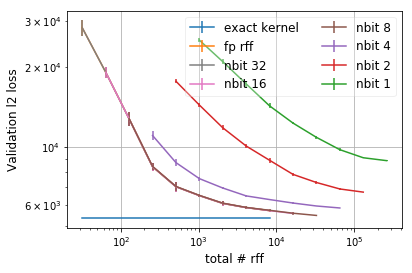

In [41]:
# plot for fixed number of features
fp_bits = 32
def get_perf_for_one_precision(subkey_list_input, general_folder=general_folder):
    fp_bits = 32
    lamb_list = ["1e-6", "1e-5", "1e-4", "1e-3", "1e-2", "1e-1", "1e0", "1e1", "1e2"]
    lamb_list_num = [float(x) for x in lamb_list]
    l2_train_mean = []
    l2_train_std = []
    l2_test_mean = []
    l2_test_std = []
    for lamb in lamb_list:
        subkey_list = subkey_list_input + ["lambda_" + lamb + "_"]
        l2_train, l2_test, lambda_list  = get_l2_error(subkey_list, general_folder)
        l2_train_mean.append(np.mean(l2_train) ) 
        l2_train_std.append(np.std(l2_train) )
        l2_test_mean.append(np.mean(l2_test) )
        l2_test_std.append(np.std(l2_test) )
    return l2_train_mean, l2_train_std, l2_test_mean, l2_test_std,
    
# # training l2
# plt.figure()
# nbit_list = [32, 16, 8, 4, 2, 1]
# n_feat_list = [32, 64, 128, 256, 512, 1024, 2048, 4096, 8192]

# # exact kernel
# train_mean_list = []
# test_mean_list = []
# train_std_list = []
# test_std_list = []
# subkey_list_input = ["exact", ]
# train_mean, train_std, test_mean, test_std = get_perf_for_one_precision(subkey_list_input, general_folder)
# test_mean_list.append(np.min(test_mean) )
# train_mean_list.append(train_mean[np.argmin(test_mean) ] )
# test_std_list.append(test_std[np.argmin(test_mean) ] )
# train_std_list.append(train_std[np.argmin(test_mean) ] )
# plt.errorbar(n_feat_list, train_mean_list * len(n_feat_list), fmt="-", yerr=train_std_list * len(n_feat_list), label="exact kernel")

# # fp results
# train_mean_list = []
# test_mean_list = []
# train_std_list = []
# test_std_list = []
# for n_feat in n_feat_list:
#     subkey_list_input = ["fp_rff", "n_fp_feat_" + str(n_feat) ]
#     train_mean, train_std, test_mean, test_std = get_perf_for_one_precision(subkey_list_input, general_folder)
#     test_mean_list.append(np.min(test_mean) )
#     train_mean_list.append(train_mean[np.argmin(test_mean) ] )
#     test_std_list.append(test_std[np.argmin(test_mean) ] )
#     train_std_list.append(train_std[np.argmin(test_mean) ] )
# plt.errorbar(n_feat_list, train_mean_list, fmt="-", yerr=train_std_list, label="fp rff")

# # lp results
# for nbit in nbit_list:
#     train_mean_list = []
#     test_mean_list = []
#     train_std_list = []
#     test_std_list = []
#     for n_feat in n_feat_list:
# #         print "nbit ", nbit, "n_feat", n_feat
#         subkey_list_input = ["lp_rff", "nbit_" + str(nbit) + "_", "n_fp_feat_" + str(n_feat) ]
#         train_mean, train_std, test_mean, test_std = get_perf_for_one_precision(subkey_list_input, general_folder)
#         test_mean_list.append(np.min(test_mean) )
#         train_mean_list.append(train_mean[np.argmin(test_mean) ] )
#         test_std_list.append(test_std[np.argmin(test_mean) ] )
#         train_std_list.append(train_std[np.argmin(test_mean) ] )
#     plt.errorbar(np.array(n_feat_list) * fp_bits / float(nbit), train_mean_list, fmt="-", yerr=train_std_list, label="reduce var lp rff nbit " + str(nbit) )

# for nbit in nbit_list:
#     train_mean_list = []
#     test_mean_list = []
#     train_std_list = []
#     test_std_list = []
#     for n_feat in n_feat_list:
# #         print "nbit ", nbit, "n_feat", n_feat
#         subkey_list_input = ["lp_rff", "nbit_" + str(nbit) + "_", "n_fp_feat_" + str(n_feat) ]
#         train_mean, train_std, test_mean, test_std = get_perf_for_one_precision(subkey_list_input, general_folder_old)
#         test_mean_list.append(np.min(test_mean) )
#         train_mean_list.append(train_mean[np.argmin(test_mean) ] )
#         test_std_list.append(test_std[np.argmin(test_mean) ] )
#         train_std_list.append(train_std[np.argmin(test_mean) ] )
#     plt.errorbar(np.array(n_feat_list) * fp_bits / float(nbit), train_mean_list, fmt="-.", yerr=train_std_list, label="lp rff nbit " + str(nbit) )


    
# ax = plt.subplot(111)
# plt.title("Train l2 loss")
# ax.set_xscale("log")
# ax.set_yscale("log")
# plt.xlabel("# of rff features")
# plt.ylabel("l2 loss")
# plt.grid()
# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# plt.show()


# test l2
plt.figure()
nbit_list = [32, 16, 8, 4, 2, 1]
n_feat_list = [32, 64, 128, 256, 512, 1024, 2048, 4096, 8192]

# exact kernel
train_mean_list = []
test_mean_list = []
train_std_list = []
test_std_list = []
subkey_list_input = ["exact", ]
train_mean, train_std, test_mean, test_std = get_perf_for_one_precision(subkey_list_input, general_folder)
test_mean_list.append(np.min(test_mean) )
train_mean_list.append(train_mean[np.argmin(test_mean) ] )
test_std_list.append(test_std[np.argmin(test_mean) ] )
train_std_list.append(train_std[np.argmin(test_mean) ] )
plt.errorbar(n_feat_list, test_mean_list * len(n_feat_list), color=colors_dict["exact"], fmt="-", yerr=test_std_list * len(n_feat_list), label="exact kernel")

# fp results
train_mean_list = []
test_mean_list = []
train_std_list = []
test_std_list = []
for n_feat in n_feat_list:
    subkey_list_input = ["fp_rff", "n_fp_feat_" + str(n_feat) ]
    train_mean, train_std, test_mean, test_std = get_perf_for_one_precision(subkey_list_input, general_folder)
    test_mean_list.append(np.min(test_mean) )
    train_mean_list.append(train_mean[np.argmin(test_mean) ] )
    test_std_list.append(test_std[np.argmin(test_mean) ] )
    train_std_list.append(train_std[np.argmin(test_mean) ] )
plt.errorbar(n_feat_list, test_mean_list, fmt="-", color=colors_dict["fp"], yerr=test_std_list, label="fp rff")

# for nbit in nbit_list:
#     train_mean_list = []
#     test_mean_list = []
#     train_std_list = []
#     test_std_list = []
#     for n_feat in n_feat_list:
# #         print "nbit ", nbit, "n_feat", n_feat
#         subkey_list_input = ["lp_rff", "nbit_" + str(nbit) + "_", "n_fp_feat_" + str(n_feat) ]
#         train_mean, train_std, test_mean, test_std = get_perf_for_one_precision(subkey_list_input, general_folder)
#         test_mean_list.append(np.min(test_mean) )
#         train_mean_list.append(train_mean[np.argmin(test_mean) ] )
#         test_std_list.append(test_std[np.argmin(test_mean) ] )
#         train_std_list.append(train_std[np.argmin(test_mean) ] )
#     plt.errorbar(np.array(n_feat_list) * fp_bits / float(nbit), test_mean_list, fmt="-", yerr=test_std_list, label="nbit " + str(nbit) )

for nbit in nbit_list:
    train_mean_list = []
    test_mean_list = []
    train_std_list = []
    test_std_list = []
    for n_feat in n_feat_list:
#         print "nbit ", nbit, "n_feat", n_feat
        subkey_list_input = ["lp_rff", "nbit_" + str(nbit) + "_", "n_fp_feat_" + str(n_feat) ]
        train_mean, train_std, test_mean, test_std = get_perf_for_one_precision(subkey_list_input, general_folder_old)
        test_mean_list.append(np.min(test_mean) )
        train_mean_list.append(train_mean[np.argmin(test_mean) ] )
        test_std_list.append(test_std[np.argmin(test_mean) ] )
        train_std_list.append(train_std[np.argmin(test_mean) ] )
    plt.errorbar(np.array(n_feat_list) * fp_bits / float(nbit), test_mean_list, color=colors_dict[str(nbit)], fmt="-", yerr=test_std_list, label="nbit " + str(nbit) )


    
ax = plt.subplot(111)
# plt.title("Test l2 loss")
ax.set_xscale("log")
ax.set_yscale("log")
# plt.ylabel("l2 loss")
# plt.xlabel("# of rff features")
# plt.grid()
# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.legend(ncol=2, fontsize=12, framealpha=0.3)
plt.ylabel("Validation l2 loss", fontsize=12)
plt.xlabel("total # rff", fontsize=12)
plt.grid()
# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig("../../notes/figures/valid_l2_n_fp.pdf", bbox_inches='tight')
plt.show()



### plot the variance reduction scheme

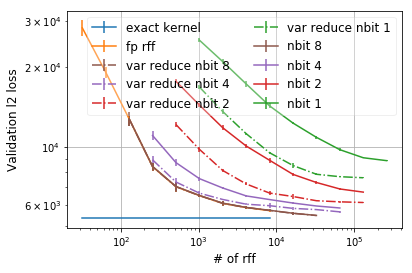

In [43]:
# plot for fixed number of features
fp_bits = 32
def get_perf_for_one_precision(subkey_list_input, general_folder=general_folder):
    fp_bits = 32
    lamb_list = ["1e-6", "1e-5", "1e-4", "1e-3", "1e-2", "1e-1", "1e0", "1e1", "1e2"]
    lamb_list_num = [float(x) for x in lamb_list]
    l2_train_mean = []
    l2_train_std = []
    l2_test_mean = []
    l2_test_std = []
    for lamb in lamb_list:
        subkey_list = subkey_list_input + ["lambda_" + lamb + "_"]
        l2_train, l2_test, lambda_list  = get_l2_error(subkey_list, general_folder)
        l2_train_mean.append(np.mean(l2_train) ) 
        l2_train_std.append(np.std(l2_train) )
        l2_test_mean.append(np.mean(l2_test) )
        l2_test_std.append(np.std(l2_test) )
    return l2_train_mean, l2_train_std, l2_test_mean, l2_test_std,
    
# # training l2
# plt.figure()
# nbit_list = [32, 16, 8, 4, 2, 1]
# n_feat_list = [32, 64, 128, 256, 512, 1024, 2048, 4096, 8192]

# # exact kernel
# train_mean_list = []
# test_mean_list = []
# train_std_list = []
# test_std_list = []
# subkey_list_input = ["exact", ]
# train_mean, train_std, test_mean, test_std = get_perf_for_one_precision(subkey_list_input, general_folder)
# test_mean_list.append(np.min(test_mean) )
# train_mean_list.append(train_mean[np.argmin(test_mean) ] )
# test_std_list.append(test_std[np.argmin(test_mean) ] )
# train_std_list.append(train_std[np.argmin(test_mean) ] )
# plt.errorbar(n_feat_list, train_mean_list * len(n_feat_list), fmt="-", yerr=train_std_list * len(n_feat_list), label="exact kernel")

# # fp results
# train_mean_list = []
# test_mean_list = []
# train_std_list = []
# test_std_list = []
# for n_feat in n_feat_list:
#     subkey_list_input = ["fp_rff", "n_fp_feat_" + str(n_feat) ]
#     train_mean, train_std, test_mean, test_std = get_perf_for_one_precision(subkey_list_input, general_folder)
#     test_mean_list.append(np.min(test_mean) )
#     train_mean_list.append(train_mean[np.argmin(test_mean) ] )
#     test_std_list.append(test_std[np.argmin(test_mean) ] )
#     train_std_list.append(train_std[np.argmin(test_mean) ] )
# plt.errorbar(n_feat_list, train_mean_list, fmt="-", yerr=train_std_list, label="fp rff")

# # lp results
# for nbit in nbit_list:
#     train_mean_list = []
#     test_mean_list = []
#     train_std_list = []
#     test_std_list = []
#     for n_feat in n_feat_list:
# #         print "nbit ", nbit, "n_feat", n_feat
#         subkey_list_input = ["lp_rff", "nbit_" + str(nbit) + "_", "n_fp_feat_" + str(n_feat) ]
#         train_mean, train_std, test_mean, test_std = get_perf_for_one_precision(subkey_list_input, general_folder)
#         test_mean_list.append(np.min(test_mean) )
#         train_mean_list.append(train_mean[np.argmin(test_mean) ] )
#         test_std_list.append(test_std[np.argmin(test_mean) ] )
#         train_std_list.append(train_std[np.argmin(test_mean) ] )
#     plt.errorbar(np.array(n_feat_list) * fp_bits / float(nbit), train_mean_list, fmt="-", yerr=train_std_list, label="reduce var lp rff nbit " + str(nbit) )

# for nbit in nbit_list:
#     train_mean_list = []
#     test_mean_list = []
#     train_std_list = []
#     test_std_list = []
#     for n_feat in n_feat_list:
# #         print "nbit ", nbit, "n_feat", n_feat
#         subkey_list_input = ["lp_rff", "nbit_" + str(nbit) + "_", "n_fp_feat_" + str(n_feat) ]
#         train_mean, train_std, test_mean, test_std = get_perf_for_one_precision(subkey_list_input, general_folder_old)
#         test_mean_list.append(np.min(test_mean) )
#         train_mean_list.append(train_mean[np.argmin(test_mean) ] )
#         test_std_list.append(test_std[np.argmin(test_mean) ] )
#         train_std_list.append(train_std[np.argmin(test_mean) ] )
#     plt.errorbar(np.array(n_feat_list) * fp_bits / float(nbit), train_mean_list, fmt="-.", yerr=train_std_list, label="lp rff nbit " + str(nbit) )


    
# ax = plt.subplot(111)
# plt.title("Train l2 loss")
# ax.set_xscale("log")
# ax.set_yscale("log")
# plt.xlabel("# of rff features")
# plt.ylabel("l2 loss")
# plt.grid()
# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# plt.show()

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

# test l2
plt.figure()
# nbit_list = [32, 16, 8, 4, 2, 1]
nbit_list = [8, 4, 2, 1]
n_feat_list = [32, 64, 128, 256, 512, 1024, 2048, 4096, 8192]

# exact kernel
train_mean_list = []
test_mean_list = []
train_std_list = []
test_std_list = []
subkey_list_input = ["exact", ]
train_mean, train_std, test_mean, test_std = get_perf_for_one_precision(subkey_list_input, general_folder)
test_mean_list.append(np.min(test_mean) )
train_mean_list.append(train_mean[np.argmin(test_mean) ] )
test_std_list.append(test_std[np.argmin(test_mean) ] )
train_std_list.append(train_std[np.argmin(test_mean) ] )
plt.errorbar(n_feat_list, test_mean_list * len(n_feat_list), fmt="-", color=colors_dict["exact"], yerr=test_std_list * len(n_feat_list), label="exact kernel")

# fp results
train_mean_list = []
test_mean_list = []
train_std_list = []
test_std_list = []
for n_feat in n_feat_list:
    subkey_list_input = ["fp_rff", "n_fp_feat_" + str(n_feat) ]
    train_mean, train_std, test_mean, test_std = get_perf_for_one_precision(subkey_list_input, general_folder)
    test_mean_list.append(np.min(test_mean) )
    train_mean_list.append(train_mean[np.argmin(test_mean) ] )
    test_std_list.append(test_std[np.argmin(test_mean) ] )
    train_std_list.append(train_std[np.argmin(test_mean) ] )
plt.errorbar(n_feat_list, test_mean_list, fmt="-", color=colors_dict['fp'], yerr=test_std_list, label="fp rff")

for idx, nbit in enumerate(nbit_list):
    train_mean_list = []
    test_mean_list = []
    train_std_list = []
    test_std_list = []
    for n_feat in n_feat_list:
#         print "nbit ", nbit, "n_feat", n_feat
        subkey_list_input = ["lp_rff", "nbit_" + str(nbit) + "_", "n_fp_feat_" + str(n_feat) ]
        train_mean, train_std, test_mean, test_std = get_perf_for_one_precision(subkey_list_input, general_folder)
        test_mean_list.append(np.min(test_mean) )
        train_mean_list.append(train_mean[np.argmin(test_mean) ] )
        test_std_list.append(test_std[np.argmin(test_mean) ] )
        train_std_list.append(train_std[np.argmin(test_mean) ] )
    plt.errorbar(np.array(n_feat_list) * fp_bits / float(nbit), test_mean_list, color=colors_dict[str(nbit)], fmt="-.", yerr=test_std_list, label="var reduce nbit " + str(nbit) )

for idx, nbit in enumerate(nbit_list):
    train_mean_list = []
    test_mean_list = []
    train_std_list = []
    test_std_list = []
    for n_feat in n_feat_list:
#         print "nbit ", nbit, "n_feat", n_feat
        subkey_list_input = ["lp_rff", "nbit_" + str(nbit) + "_", "n_fp_feat_" + str(n_feat) ]
        train_mean, train_std, test_mean, test_std = get_perf_for_one_precision(subkey_list_input, general_folder_old)
        test_mean_list.append(np.min(test_mean) )
        train_mean_list.append(train_mean[np.argmin(test_mean) ] )
        test_std_list.append(test_std[np.argmin(test_mean) ] )
        train_std_list.append(train_std[np.argmin(test_mean) ] )
    plt.errorbar(np.array(n_feat_list) * fp_bits / float(nbit), test_mean_list, fmt="-",color=colors_dict[str(nbit)], yerr=test_std_list, label="nbit " + str(nbit) )


    
ax = plt.subplot(111)
# plt.title("Test l2 loss")
ax.set_xscale("log")
ax.set_yscale("log")
# plt.ylabel("l2 loss")
# plt.xlabel("# of rff features")
# plt.grid()
# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.legend(ncol=2, fontsize=12, framealpha=0.3)
plt.ylabel("Validation l2 loss", fontsize=12)
plt.xlabel("# of rff", fontsize=12)
plt.grid()
# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig("../../notes/figures/valid_l2_n_fp_var_reduction.pdf", bbox_inches='tight')
plt.show()


### plot tarin and test l2 loss for the largest number of full precision features

# 8192

Exact kernel
[1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0]


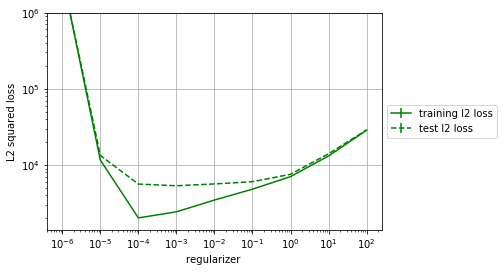

Full precision rff kernel
[1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0]


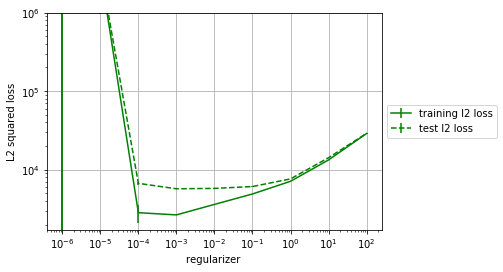

32 bit lp rff kernel
[1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0]


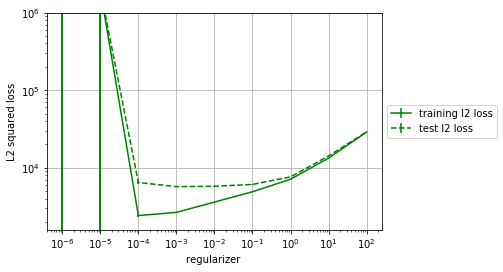

16 bit lp rff kernel
[1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0]


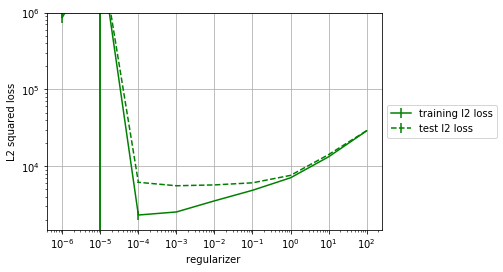

8 bit lp rff kernel
[1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0]


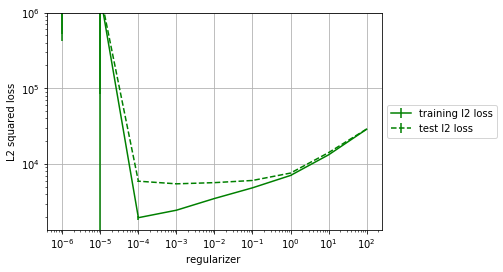

4 bit lp rff kernel
[1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0]


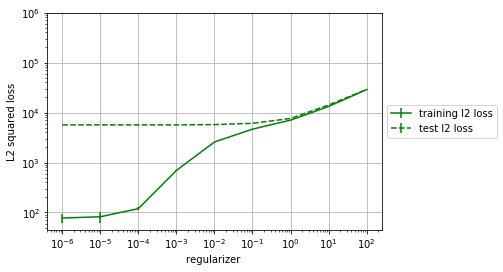

2 bit lp rff kernel
[1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0]


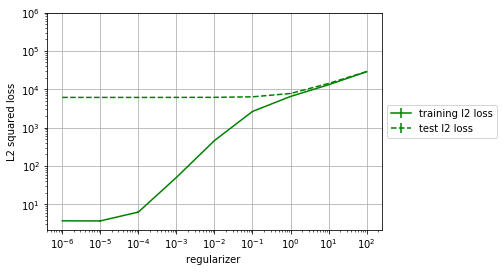

1 bit lp rff kernel
[1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0]


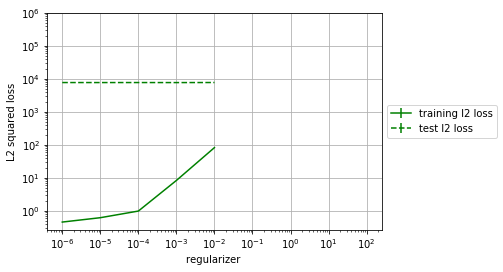

In [15]:
# plot for fixed number of features
def plot_single_precision(subkey_list_input):
    fp_bits = 32
    plt.figure()
    # n_feat_list = [32, 64, 128, 256, 512, 1024, 2048, 4096, 8192]
    lamb_list = ["1e-6", "1e-5", "1e-4", "1e-3", "1e-2", "1e-1", "1e0", "1e1", "1e2"]
    lamb_list_num = [float(x) for x in lamb_list]
    print lamb_list_num
    l2_train_mean = []
    l2_train_std = []
    l2_test_mean = []
    l2_test_std = []
    for lamb in lamb_list:
        subkey_list = subkey_list_input + ["lambda_" + lamb + "_"]
        l2_train, l2_test, lambda_list  = get_l2_error(subkey_list, general_folder)
        l2_train_mean.append(np.mean(l2_train) ) # = [l2_train[np.argmin(l2_test) ], ] * len(n_feat_list)
        l2_train_std.append(np.std(l2_train) ) # = [np.min(l2_test), ] * len(n_feat_list)
        l2_test_mean.append(np.mean(l2_test) ) # = [l2_train[np.argmin(l2_test) ], ] * len(n_feat_list)
        l2_test_std.append(np.std(l2_test) ) # = [np.min(l2_test), ] * len(n_feat_list)
    plt.errorbar(lamb_list_num, l2_train_mean, yerr=l2_train_std, fmt="g", label="training l2 loss")
    plt.errorbar(lamb_list_num, l2_test_mean, yerr=l2_test_std, fmt="g--", label="test l2 loss")
#     plt.errorbar(lamb_list_num, l2_train_mean, yerr=[x * 100 for x in l2_train_std], fmt="g", label="training l2 loss")
#     plt.errorbar(lamb_list_num, l2_test_mean, yerr=[x * 100 for x in l2_test_std] , fmt="g--", label="test l2 loss")
    ax = plt.subplot(111)
    ax.set_xscale("log")
    ax.set_yscale("log")
    plt.grid()
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5) )
    plt.xlabel("regularizer ")
    plt.ylabel("L2 squared loss")
    plt.ylim([None, 1e6])
    plt.show()
print("Exact kernel")
plot_single_precision(subkey_list_input=["exact", ])
print("Full precision rff kernel")
plot_single_precision(subkey_list_input=["fp_rff", "n_fp_feat_8192"])
print("32 bit lp rff kernel")
plot_single_precision(subkey_list_input=["lp_rff", "nbit_32_", "n_fp_feat_8192"])
print("16 bit lp rff kernel")
plot_single_precision(subkey_list_input=["lp_rff", "nbit_16_", "n_fp_feat_8192"])
print("8 bit lp rff kernel")
plot_single_precision(subkey_list_input=["lp_rff", "nbit_8_", "n_fp_feat_8192"])
print("4 bit lp rff kernel")
plot_single_precision(subkey_list_input=["lp_rff", "nbit_4_", "n_fp_feat_8192"])
print("2 bit lp rff kernel")
plot_single_precision(subkey_list_input=["lp_rff", "nbit_2_", "n_fp_feat_8192"])
print("1 bit lp rff kernel")
plot_single_precision(subkey_list_input=["lp_rff", "nbit_1_", "n_fp_feat_8192"])


Exact kernel
[1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
0.001


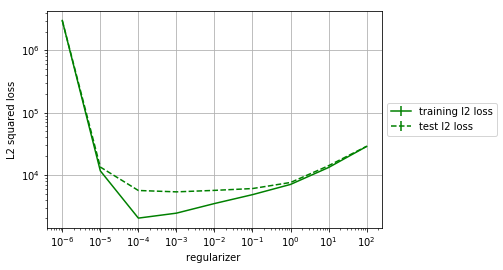

Full precision rff kernel
[1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
0.001


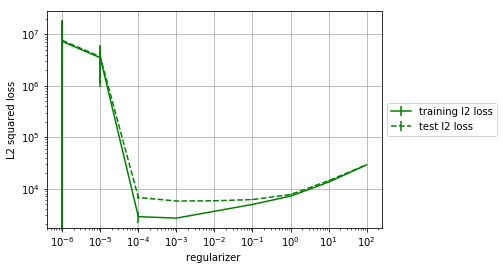

32 bit lp rff kernel
[1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
0.001


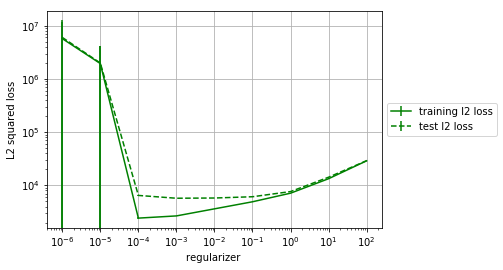

16 bit lp rff kernel
[1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
0.001


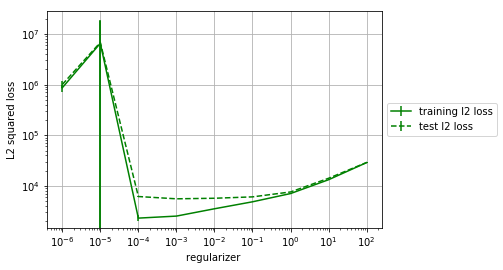

8 bit lp rff kernel
[1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
0.001


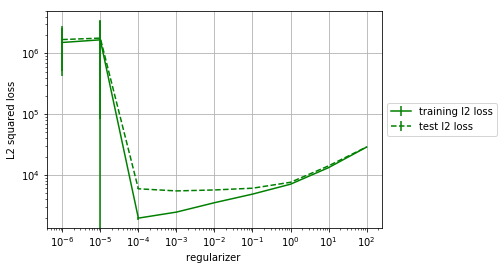

4 bit lp rff kernel
[1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
0.001


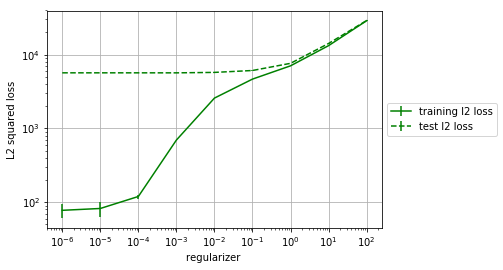

2 bit lp rff kernel
[1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
1e-05


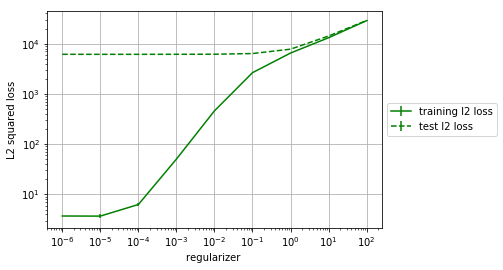

1 bit lp rff kernel
[1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
0.1


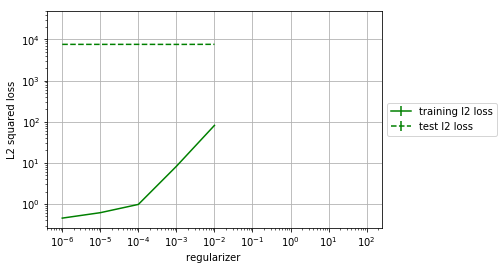

In [16]:
# plot for fixed number of features
def plot_single_precision(subkey_list_input):
    fp_bits = 32
    plt.figure()
    # n_feat_list = [32, 64, 128, 256, 512, 1024, 2048, 4096, 8192]
    lamb_list = ["1e-6", "1e-5", "1e-4", "1e-3", "1e-2", "1e-1", "1e0", "1e1", "1e2"]
    lamb_list_num = [float(x) for x in lamb_list]
    print lamb_list_num
    l2_train_mean = []
    l2_train_std = []
    l2_test_mean = []
    l2_test_std = []
    for lamb in lamb_list:
        subkey_list = subkey_list_input + ["lambda_" + lamb + "_"]
        l2_train, l2_test, lambda_list  = get_l2_error(subkey_list, general_folder)
        l2_train_mean.append(np.mean(l2_train) ) # = [l2_train[np.argmin(l2_test) ], ] * len(n_feat_list)
        l2_train_std.append(np.std(l2_train) ) # = [np.min(l2_test), ] * len(n_feat_list)
        l2_test_mean.append(np.mean(l2_test) ) # = [l2_train[np.argmin(l2_test) ], ] * len(n_feat_list)
        l2_test_std.append(np.std(l2_test) ) # = [np.min(l2_test), ] * len(n_feat_list)
    print lamb_list_num[np.argmin(l2_test_mean) ]
    plt.errorbar(lamb_list_num, l2_train_mean, yerr=l2_train_std, fmt="g", label="training l2 loss")
    plt.errorbar(lamb_list_num, l2_test_mean, yerr=l2_test_std, fmt="g--", label="test l2 loss")
#     plt.errorbar(lamb_list_num, l2_train_mean, yerr=[x * 100 for x in l2_train_std], fmt="g", label="training l2 loss")
#     plt.errorbar(lamb_list_num, l2_test_mean, yerr=[x * 100 for x in l2_test_std] , fmt="g--", label="test l2 loss")
    ax = plt.subplot(111)
    ax.set_xscale("log")
    ax.set_yscale("log")
    plt.grid()
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5) )
    plt.xlabel("regularizer ")
    plt.ylabel("L2 squared loss")
#     plt.ylim([None, 1e6])
    plt.show()
print("Exact kernel")
plot_single_precision(subkey_list_input=["exact", ])
print("Full precision rff kernel")
plot_single_precision(subkey_list_input=["fp_rff", "n_fp_feat_8192"])
print("32 bit lp rff kernel")
plot_single_precision(subkey_list_input=["lp_rff", "nbit_32_", "n_fp_feat_8192"])
print("16 bit lp rff kernel")
plot_single_precision(subkey_list_input=["lp_rff", "nbit_16_", "n_fp_feat_8192"])
print("8 bit lp rff kernel")
plot_single_precision(subkey_list_input=["lp_rff", "nbit_8_", "n_fp_feat_8192"])
print("4 bit lp rff kernel")
plot_single_precision(subkey_list_input=["lp_rff", "nbit_4_", "n_fp_feat_8192"])
print("2 bit lp rff kernel")
plot_single_precision(subkey_list_input=["lp_rff", "nbit_2_", "n_fp_feat_8192"])
print("1 bit lp rff kernel")
plot_single_precision(subkey_list_input=["lp_rff", "nbit_1_", "n_fp_feat_8192"])



In [17]:
# plot for fixed number of features
fp_bits = 32
plt.figure()
n_feat_list = [1024, 4096, 16384]
# get exact kernel info
subkey_list = ["exact",]
l2_train, l2_test, lambda_list  = get_l2_error(subkey_list, dict_res)
l2_train_list = [l2_train[np.argmin(l2_test) ], ] * len(n_feat_list)
l2_test_list = [np.min(l2_test), ] * len(n_feat_list)
print "exact lambda ", lambda_list[np.argmin(l2_test) ], "min/max"#, \
#     len(lambda_list), lambda_list#     np.min(lambda_list), np.max(lambda_list)
plt.plot(np.array(n_feat_list) * fp_bits, l2_train_list, "g", label="exact kernel training l2 loss")
plt.plot(np.array(n_feat_list) * fp_bits, l2_test_list, "g--", label="exact kernel test l2 loss")

# plot full precision kernel approximation
l2_train_list = []
l2_test_list = []
for n_feat in n_feat_list:
    subkey_list = ["fp_rff_lambda", "n_fp_rff_" + str(n_feat) ]
    l2_train, l2_test, lambda_list  = get_l2_error(subkey_list, dict_res)
    l2_train_list.append(l2_train[np.argmin(l2_test) ] )
    l2_test_list.append(np.min(l2_test) )
    print "fp ", n_feat, " features, lambda ", lambda_list[np.argmin(l2_test) ], "min/max"#, \
#         len(lambda_list), lambda_list#         np.min(lambda_list), np.max(lambda_list)

plt.plot(np.array(n_feat_list) * fp_bits, l2_train_list, "r", label="fp rff training l2 loss")
plt.plot(np.array(n_feat_list) * fp_bits, l2_test_list, "r--", label="fp rff test l2 loss")

colors = ["g", 'b', 'k', 'c', 'm', 'y']
# note the error bar need to be replotted due to different number of samples
for i, n_bit in enumerate( [32, 16, 8, 4, 2, 1] ):
    l2_train_list = []
    l2_test_list = []
    for n_feat in n_feat_list:
        subkey_list = ["lp_rff_lambda", "n_fp_rff_" + str(n_feat), "nbit_" + str(n_bit) ]
        l2_train, l2_test, lambda_list  = get_l2_error(subkey_list, dict_res)
        l2_train_list.append(l2_train[np.argmin(l2_test) ] )
        l2_test_list.append(np.min(l2_test) )
        print n_bit, " bits lp ", n_feat, " features, lambda ", lambda_list[np.argmin(l2_test) ]#, "min/max", \
#             len(lambda_list), lambda_list#             np.min(lambda_list), np.max(lambda_list)

#     plt.errorbar(np.array(n_feat_list) * fp_bits, mean_error, yerr=std_error, label="lp rff nbit="+str(n_bit) )
    plt.plot(np.array(n_feat_list) * fp_bits, l2_train_list, colors[i], label="lp rff training l2 loss nbit=" + str(n_bit))
    plt.plot(np.array(n_feat_list) * fp_bits, l2_test_list, colors[i] + "--", label="lp rff test l2 loss nbit=" + str(n_bit))

    
ax = plt.subplot(111)
ax.set_xscale("log")
ax.set_yscale("log")
plt.grid()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5) )
plt.xlabel("total # bits for rff ")
plt.ylabel("L2 squared loss")
plt.xlim([n_feat_list[0] * 0.9 * fp_bits, n_feat_list[-1] * 1.1 * fp_bits])
plt.ylim([1e3, 1e4])
plt.show()

NameError: name 'dict_res' is not defined

# 4096

Exact kernel
[1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
0.001


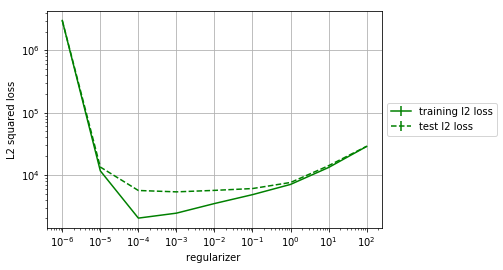

Full precision rff kernel
[1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
0.01


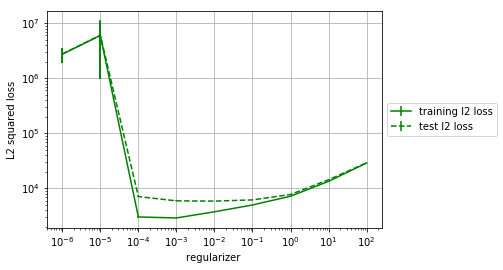

32 bit lp rff kernel
[1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
0.01


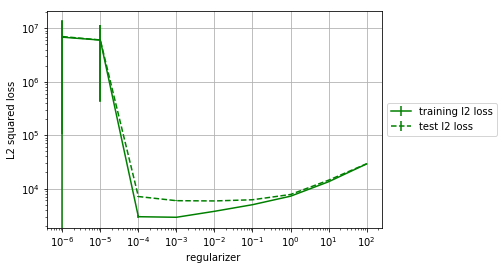

16 bit lp rff kernel
[1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
0.001


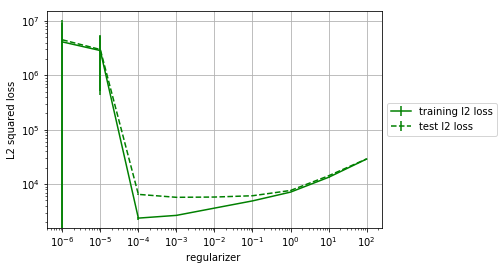

8 bit lp rff kernel
[1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
0.001


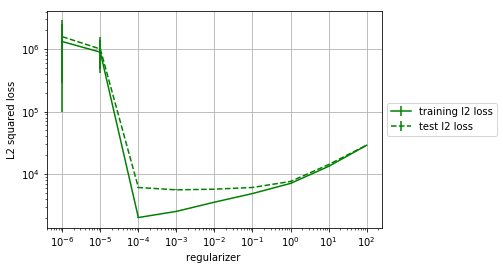

4 bit lp rff kernel
[1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
0.01


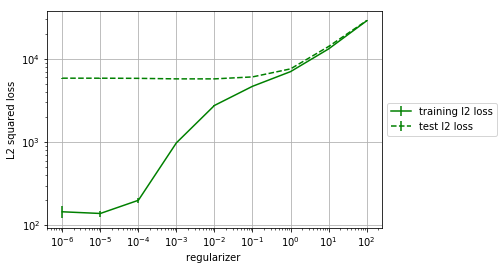

2 bit lp rff kernel
[1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
1e-06


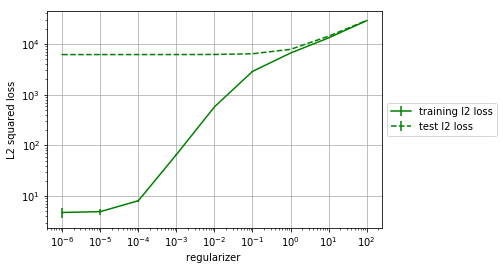

1 bit lp rff kernel
[1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
0.0001


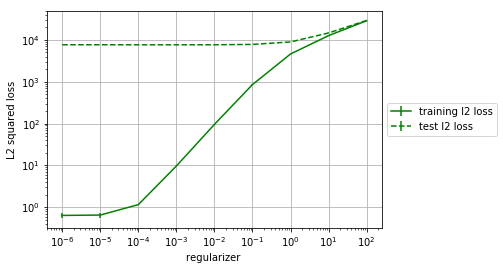

In [18]:
# plot for fixed number of features
def plot_single_precision(subkey_list_input):
    fp_bits = 32
    plt.figure()
    # n_feat_list = [32, 64, 128, 256, 512, 1024, 2048, 4096, 8192]
    lamb_list = ["1e-6", "1e-5", "1e-4", "1e-3", "1e-2", "1e-1", "1e0", "1e1", "1e2"]
    lamb_list_num = [float(x) for x in lamb_list]
    print lamb_list_num
    l2_train_mean = []
    l2_train_std = []
    l2_test_mean = []
    l2_test_std = []
    for lamb in lamb_list:
        subkey_list = subkey_list_input + ["lambda_" + lamb + "_"]
        l2_train, l2_test, lambda_list  = get_l2_error(subkey_list, general_folder)
        l2_train_mean.append(np.mean(l2_train) ) # = [l2_train[np.argmin(l2_test) ], ] * len(n_feat_list)
        l2_train_std.append(np.std(l2_train) ) # = [np.min(l2_test), ] * len(n_feat_list)
        l2_test_mean.append(np.mean(l2_test) ) # = [l2_train[np.argmin(l2_test) ], ] * len(n_feat_list)
        l2_test_std.append(np.std(l2_test) ) # = [np.min(l2_test), ] * len(n_feat_list)
    print lamb_list_num[np.argmin(l2_test_mean) ]
    plt.errorbar(lamb_list_num, l2_train_mean, yerr=l2_train_std, fmt="g", label="training l2 loss")
    plt.errorbar(lamb_list_num, l2_test_mean, yerr=l2_test_std, fmt="g--", label="test l2 loss")
#     plt.errorbar(lamb_list_num, l2_train_mean, yerr=[x * 100 for x in l2_train_std], fmt="g", label="training l2 loss")
#     plt.errorbar(lamb_list_num, l2_test_mean, yerr=[x * 100 for x in l2_test_std] , fmt="g--", label="test l2 loss")
    ax = plt.subplot(111)
    ax.set_xscale("log")
    ax.set_yscale("log")
    plt.grid()
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5) )
    plt.xlabel("regularizer ")
    plt.ylabel("L2 squared loss")
#     plt.ylim([None, 1e6])
    plt.show()
print("Exact kernel")
plot_single_precision(subkey_list_input=["exact", ])
print("Full precision rff kernel")
plot_single_precision(subkey_list_input=["fp_rff", "n_fp_feat_4096"])
print("32 bit lp rff kernel")
plot_single_precision(subkey_list_input=["lp_rff", "nbit_32_", "n_fp_feat_4096"])
print("16 bit lp rff kernel")
plot_single_precision(subkey_list_input=["lp_rff", "nbit_16_", "n_fp_feat_4096"])
print("8 bit lp rff kernel")
plot_single_precision(subkey_list_input=["lp_rff", "nbit_8_", "n_fp_feat_4096"])
print("4 bit lp rff kernel")
plot_single_precision(subkey_list_input=["lp_rff", "nbit_4_", "n_fp_feat_4096"])
print("2 bit lp rff kernel")
plot_single_precision(subkey_list_input=["lp_rff", "nbit_2_", "n_fp_feat_4096"])
print("1 bit lp rff kernel")
plot_single_precision(subkey_list_input=["lp_rff", "nbit_1_", "n_fp_feat_4096"])

# 2048

Exact kernel
[1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
0.001


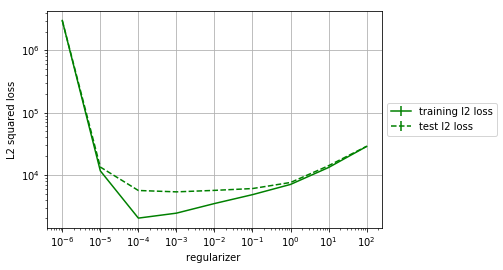

Full precision rff kernel
[1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
0.01


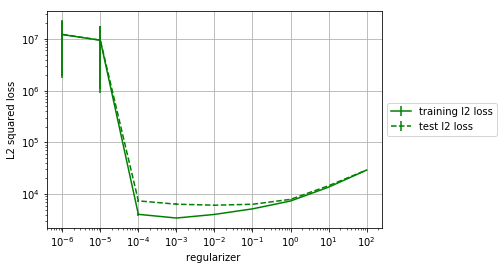

32 bit lp rff kernel
[1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
0.01


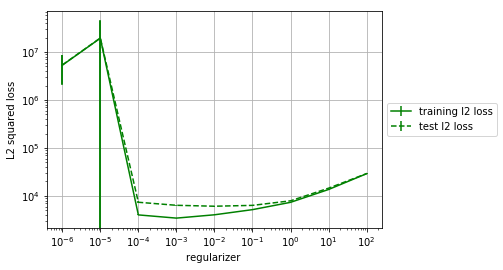

16 bit lp rff kernel
[1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
0.01


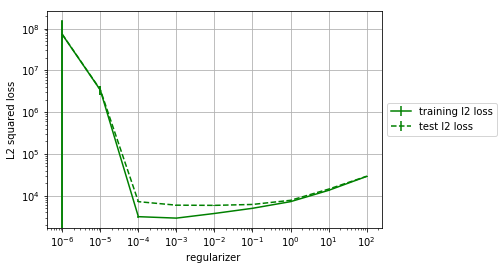

8 bit lp rff kernel
[1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
0.001


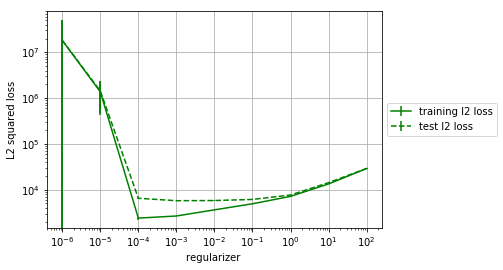

4 bit lp rff kernel
[1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
0.01


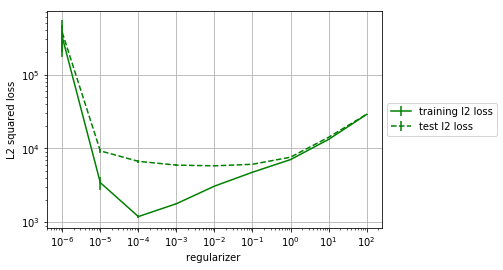

2 bit lp rff kernel
[1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
0.0001


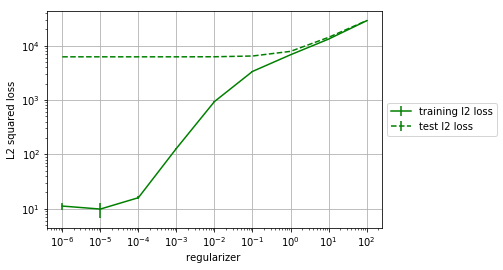

1 bit lp rff kernel
[1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
1e-06


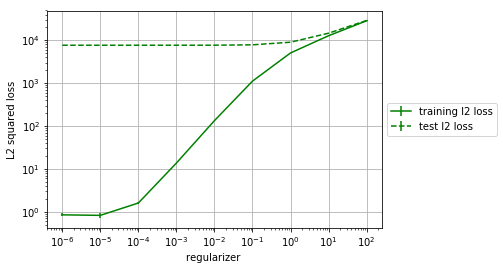

In [19]:
# plot for fixed number of features
def plot_single_precision(subkey_list_input):
    fp_bits = 32
    plt.figure()
    # n_feat_list = [32, 64, 128, 256, 512, 1024, 2048, 4096, 8192]
    lamb_list = ["1e-6", "1e-5", "1e-4", "1e-3", "1e-2", "1e-1", "1e0", "1e1", "1e2"]
    lamb_list_num = [float(x) for x in lamb_list]
    print lamb_list_num
    l2_train_mean = []
    l2_train_std = []
    l2_test_mean = []
    l2_test_std = []
    for lamb in lamb_list:
        subkey_list = subkey_list_input + ["lambda_" + lamb + "_"]
        l2_train, l2_test, lambda_list  = get_l2_error(subkey_list, general_folder)
        l2_train_mean.append(np.mean(l2_train) ) # = [l2_train[np.argmin(l2_test) ], ] * len(n_feat_list)
        l2_train_std.append(np.std(l2_train) ) # = [np.min(l2_test), ] * len(n_feat_list)
        l2_test_mean.append(np.mean(l2_test) ) # = [l2_train[np.argmin(l2_test) ], ] * len(n_feat_list)
        l2_test_std.append(np.std(l2_test) ) # = [np.min(l2_test), ] * len(n_feat_list)
    print lamb_list_num[np.argmin(l2_test_mean) ]
    plt.errorbar(lamb_list_num, l2_train_mean, yerr=l2_train_std, fmt="g", label="training l2 loss")
    plt.errorbar(lamb_list_num, l2_test_mean, yerr=l2_test_std, fmt="g--", label="test l2 loss")
#     plt.errorbar(lamb_list_num, l2_train_mean, yerr=[x * 100 for x in l2_train_std], fmt="g", label="training l2 loss")
#     plt.errorbar(lamb_list_num, l2_test_mean, yerr=[x * 100 for x in l2_test_std] , fmt="g--", label="test l2 loss")
    ax = plt.subplot(111)
    ax.set_xscale("log")
    ax.set_yscale("log")
    plt.grid()
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5) )
    plt.xlabel("regularizer ")
    plt.ylabel("L2 squared loss")
#     plt.ylim([None, 1e6])
    plt.show()
print("Exact kernel")
plot_single_precision(subkey_list_input=["exact", ])
print("Full precision rff kernel")
plot_single_precision(subkey_list_input=["fp_rff", "n_fp_feat_2048"])
print("32 bit lp rff kernel")
plot_single_precision(subkey_list_input=["lp_rff", "nbit_32_", "n_fp_feat_2048"])
print("16 bit lp rff kernel")
plot_single_precision(subkey_list_input=["lp_rff", "nbit_16_", "n_fp_feat_2048"])
print("8 bit lp rff kernel")
plot_single_precision(subkey_list_input=["lp_rff", "nbit_8_", "n_fp_feat_2048"])
print("4 bit lp rff kernel")
plot_single_precision(subkey_list_input=["lp_rff", "nbit_4_", "n_fp_feat_2048"])
print("2 bit lp rff kernel")
plot_single_precision(subkey_list_input=["lp_rff", "nbit_2_", "n_fp_feat_2048"])
print("1 bit lp rff kernel")
plot_single_precision(subkey_list_input=["lp_rff", "nbit_1_", "n_fp_feat_2048"])

# 1024

Exact kernel
[1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
0.001


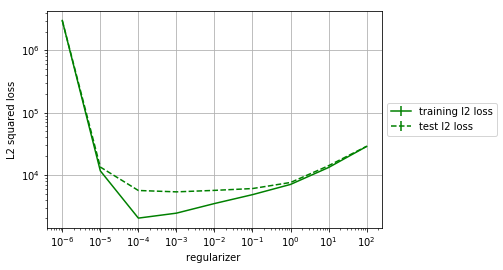

Full precision rff kernel
[1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
0.01


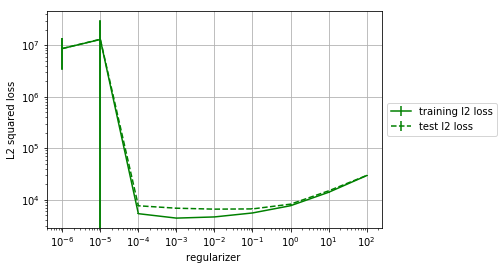

32 bit lp rff kernel
[1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
0.01


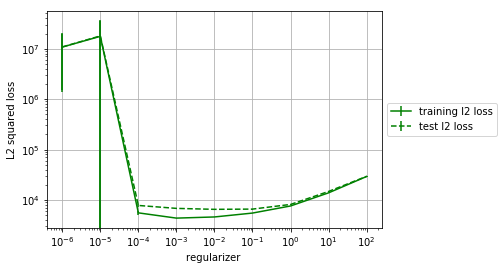

16 bit lp rff kernel
[1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
0.01


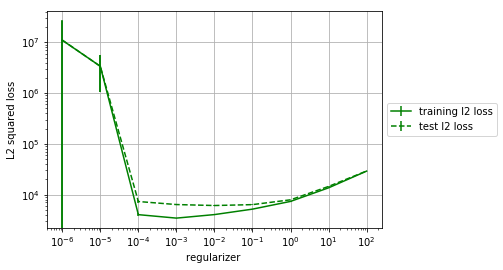

8 bit lp rff kernel
[1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
0.01


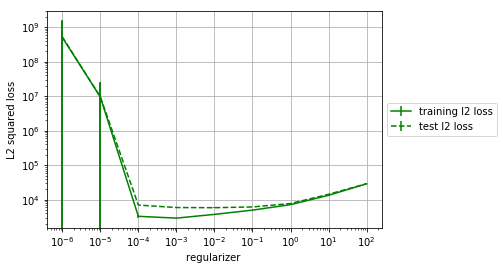

4 bit lp rff kernel
[1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
0.01


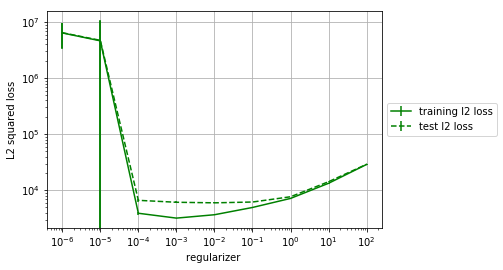

2 bit lp rff kernel
[1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
0.01


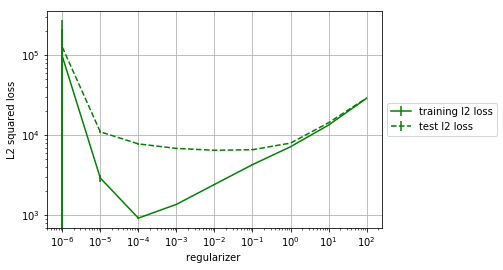

1 bit lp rff kernel
[1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
1e-05


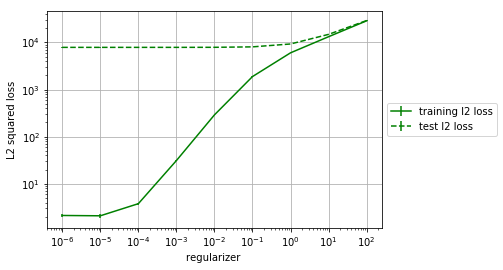

In [20]:
# plot for fixed number of features
def plot_single_precision(subkey_list_input):
    fp_bits = 32
    plt.figure()
    # n_feat_list = [32, 64, 128, 256, 512, 1024, 2048, 4096, 8192]
    lamb_list = ["1e-6", "1e-5", "1e-4", "1e-3", "1e-2", "1e-1", "1e0", "1e1", "1e2"]
    lamb_list_num = [float(x) for x in lamb_list]
    print lamb_list_num
    l2_train_mean = []
    l2_train_std = []
    l2_test_mean = []
    l2_test_std = []
    for lamb in lamb_list:
        subkey_list = subkey_list_input + ["lambda_" + lamb + "_"]
        l2_train, l2_test, lambda_list  = get_l2_error(subkey_list, general_folder)
        l2_train_mean.append(np.mean(l2_train) ) # = [l2_train[np.argmin(l2_test) ], ] * len(n_feat_list)
        l2_train_std.append(np.std(l2_train) ) # = [np.min(l2_test), ] * len(n_feat_list)
        l2_test_mean.append(np.mean(l2_test) ) # = [l2_train[np.argmin(l2_test) ], ] * len(n_feat_list)
        l2_test_std.append(np.std(l2_test) ) # = [np.min(l2_test), ] * len(n_feat_list)
    print lamb_list_num[np.argmin(l2_test_mean) ]
    plt.errorbar(lamb_list_num, l2_train_mean, yerr=l2_train_std, fmt="g", label="training l2 loss")
    plt.errorbar(lamb_list_num, l2_test_mean, yerr=l2_test_std, fmt="g--", label="test l2 loss")
#     plt.errorbar(lamb_list_num, l2_train_mean, yerr=[x * 100 for x in l2_train_std], fmt="g", label="training l2 loss")
#     plt.errorbar(lamb_list_num, l2_test_mean, yerr=[x * 100 for x in l2_test_std] , fmt="g--", label="test l2 loss")
    ax = plt.subplot(111)
    ax.set_xscale("log")
    ax.set_yscale("log")
    plt.grid()
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5) )
    plt.xlabel("regularizer ")
    plt.ylabel("L2 squared loss")
#     plt.ylim([None, 1e6])
    plt.show()
print("Exact kernel")
plot_single_precision(subkey_list_input=["exact", ])
print("Full precision rff kernel")
plot_single_precision(subkey_list_input=["fp_rff", "n_fp_feat_1024"])
print("32 bit lp rff kernel")
plot_single_precision(subkey_list_input=["lp_rff", "nbit_32_", "n_fp_feat_1024"])
print("16 bit lp rff kernel")
plot_single_precision(subkey_list_input=["lp_rff", "nbit_16_", "n_fp_feat_1024"])
print("8 bit lp rff kernel")
plot_single_precision(subkey_list_input=["lp_rff", "nbit_8_", "n_fp_feat_1024"])
print("4 bit lp rff kernel")
plot_single_precision(subkey_list_input=["lp_rff", "nbit_4_", "n_fp_feat_1024"])
print("2 bit lp rff kernel")
plot_single_precision(subkey_list_input=["lp_rff", "nbit_2_", "n_fp_feat_1024"])
print("1 bit lp rff kernel")
plot_single_precision(subkey_list_input=["lp_rff", "nbit_1_", "n_fp_feat_1024"])

# Code below are not useful

### plot exact kernel v.s. regularizer (kernel approximation error, L2 loss)

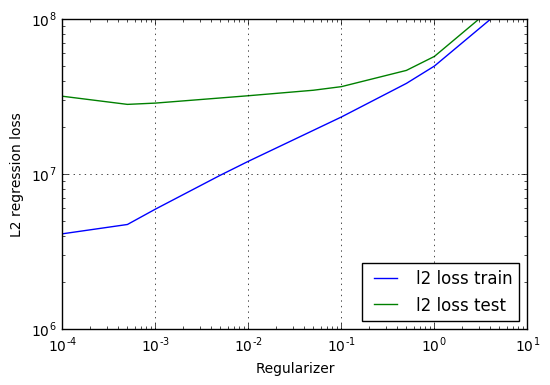

In [32]:
reg_lambda_list = []
l2_error_train_list = []
l2_error_test_list = []
tmp_dict = []
for key in dict_res.keys():
    if "exact" in key:
        tmp_dict.append((key, dict_res[key] ) )
tmp_dict = sorted(tmp_dict, key=lambda x: float(x[0].split("_lambda_")[1].split("_")[0] ))
for item in tmp_dict:
    reg_lambda = float(item[0].split("_lambda_")[1].split("_")[0] )
    reg_lambda_list.append(reg_lambda)
    l2_error_train_list.append(item[1]["train_l2_error"] )
    l2_error_test_list.append(item[1]["test_l2_error"] )        
plt.figure()
plt.loglog(reg_lambda_list, l2_error_train_list, label="l2 loss train")
plt.loglog(reg_lambda_list, l2_error_test_list, label="l2 loss test")
plt.xlabel("Regularizer")
plt.ylabel("L2 regression loss")
plt.ylim([1e6, 1e8])
plt.grid()
plt.legend(loc="lower right")
plt.show()        

### plot fp kernel v.s. exact kernel (of best regularizer)

('using n feature ', 1024)


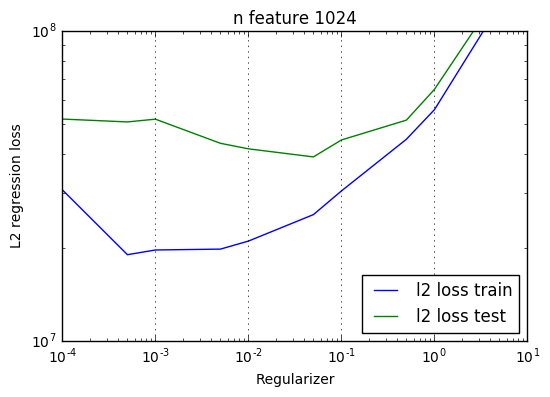

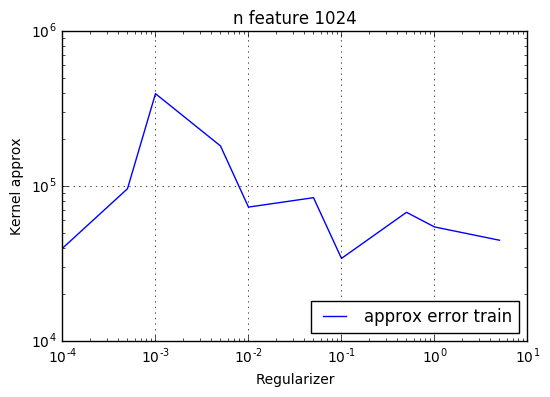

('using n feature ', 4096)


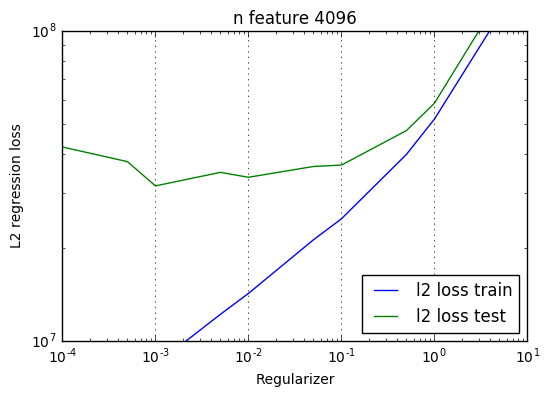

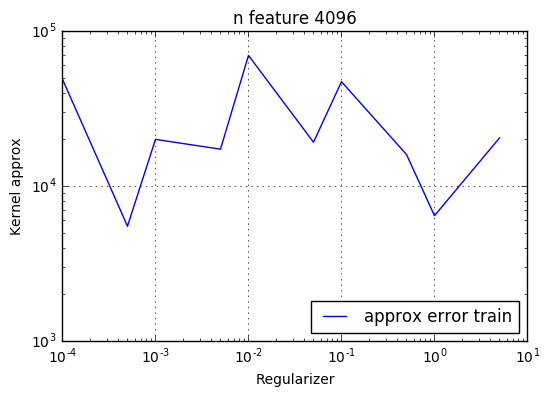

('using n feature ', 16384)


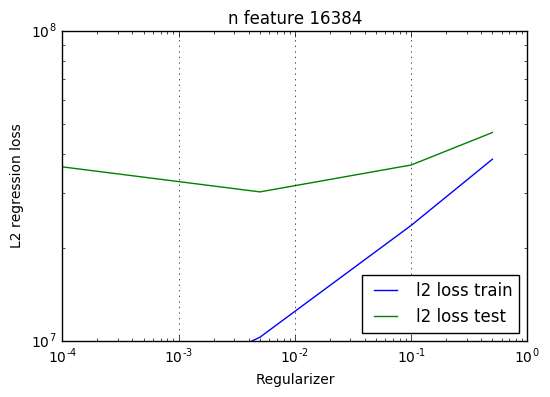

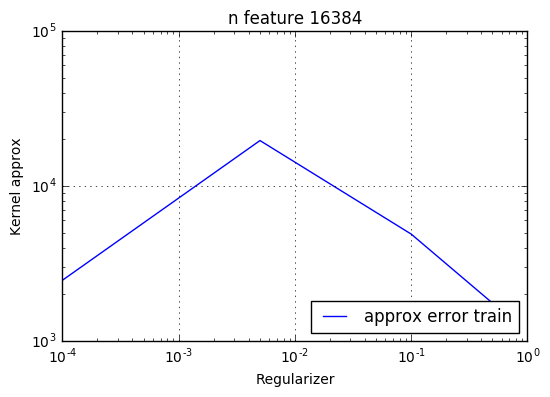

('using n feature ', 65536)
('using n feature ', 262144)
('using n feature ', 1048576)


In [48]:
def get_fp_rff_res(n_feat):
    reg_lambda_list = []
    l2_error_train_list = []
    l2_error_test_list = []
    approx_error_train_list = []
    tmp_dict = []
    for key in dict_res.keys():
        if key.startswith("fp") and "n_fp_rff_" + str(n_feat) in key:
            tmp_dict.append((key, dict_res[key] ) )
    tmp_dict = sorted(tmp_dict, key=lambda x: float(x[0].split("_lambda_")[1].split("_")[0] ))  
#     print tmp_dict
#     raw_input()
    for item in tmp_dict:
        reg_lambda = float(item[0].split("_lambda_")[1].split("_")[0] )
        reg_lambda_list.append(reg_lambda)
        l2_error_train_list.append(item[1]["train_l2_error"] )
        l2_error_test_list.append(item[1]["test_l2_error"] )
        approx_error_train_list.append(item[1]["train_approx_error"])
    return reg_lambda_list, l2_error_train_list, l2_error_test_list, approx_error_train_list

for n_feat in [1024, 4096, 16384, 65536, 262144, 1048576]:
    reg_lambda_list, l2_error_train_list, l2_error_test_list, approx_error_train_list = \
        get_fp_rff_res(n_feat)
    print("using n feature ", n_feat)
    if len(reg_lambda_list) == 0:
        continue
    plt.figure()
    plt.loglog(reg_lambda_list, l2_error_train_list, label="l2 loss train")
    plt.loglog(reg_lambda_list, l2_error_test_list, label="l2 loss test")
    plt.xlabel("Regularizer")
    plt.ylabel("L2 regression loss")
    plt.title("n feature " + str(n_feat))
    plt.ylim([1e7, 1e8])
    plt.grid()
    plt.legend(loc="lower right")
    plt.show()

    plt.figure()
    plt.loglog(reg_lambda_list, approx_error_train_list, label="approx error train")
    plt.xlabel("Regularizer")
    plt.ylabel("Kernel approx")
    plt.title("n feature " + str(n_feat))
    plt.grid()
    plt.legend(loc="lower right")
    plt.show()

### plot fp kernel v.s. lp kernel (of best regularizer)

('using n feature / n bit', 1024, 16)


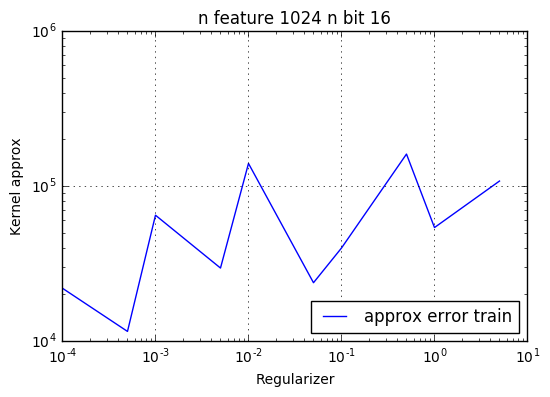

('using n feature / n bit', 4096, 16)


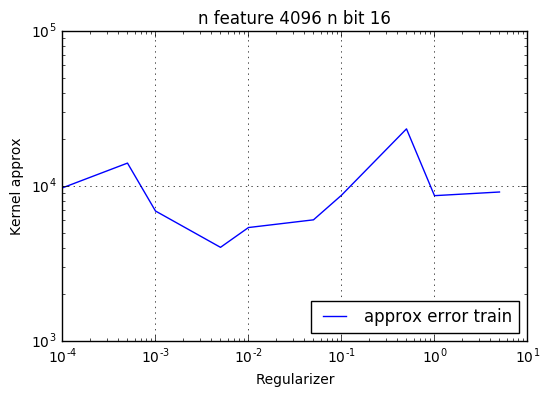

('using n feature / n bit', 16384, 16)


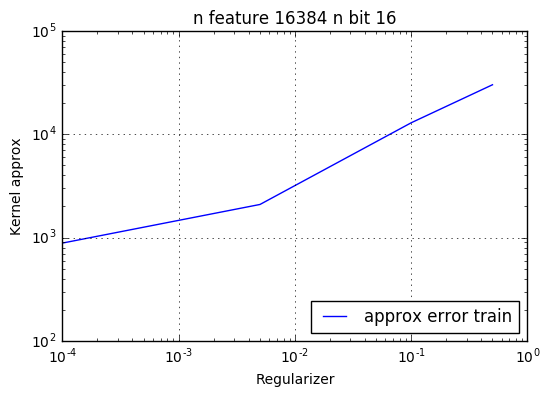

('using n feature / n bit', 65536, 16)
('using n feature / n bit', 262144, 16)
('using n feature / n bit', 1048576, 16)
('using n feature / n bit', 1024, 8)


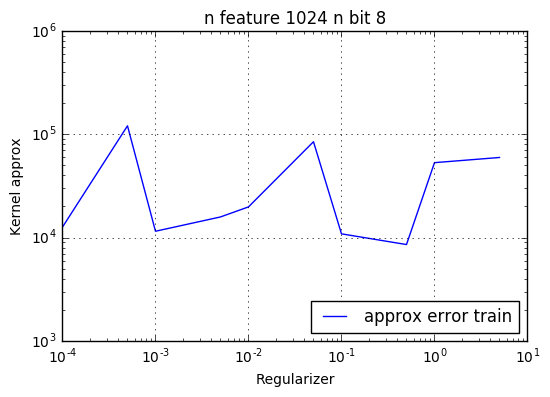

('using n feature / n bit', 4096, 8)


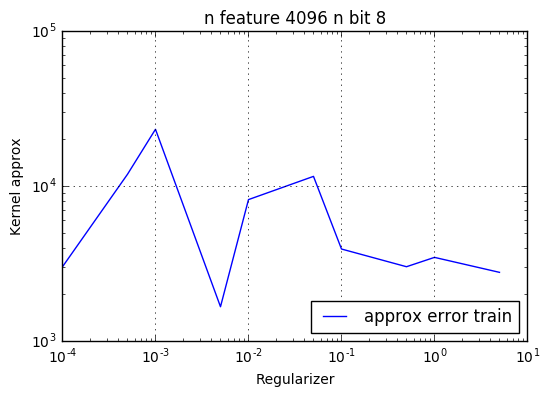

('using n feature / n bit', 16384, 8)


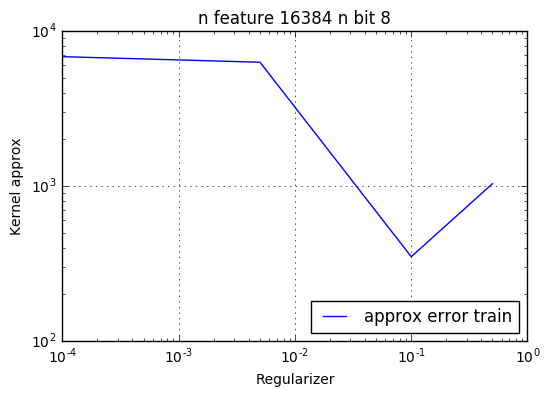

('using n feature / n bit', 65536, 8)
('using n feature / n bit', 262144, 8)
('using n feature / n bit', 1048576, 8)
('using n feature / n bit', 1024, 4)


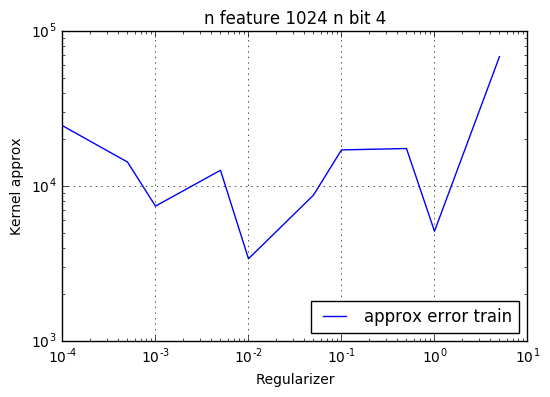

('using n feature / n bit', 4096, 4)


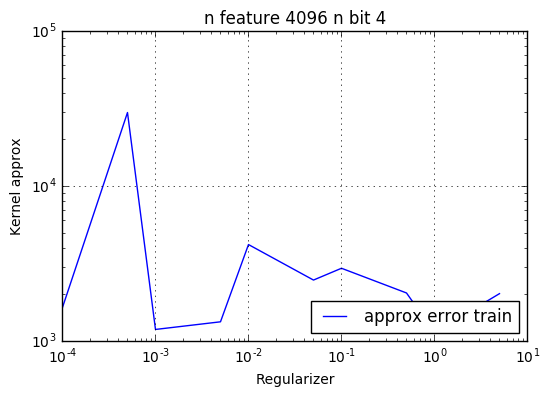

('using n feature / n bit', 16384, 4)


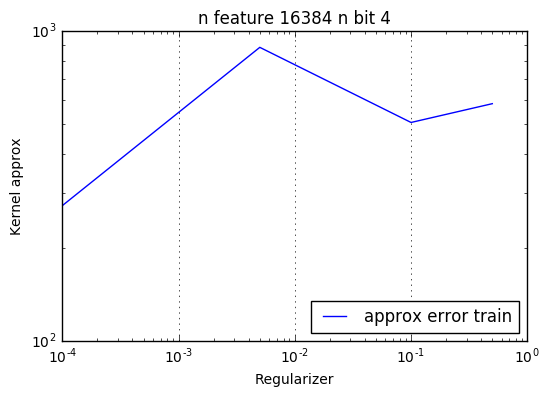

('using n feature / n bit', 65536, 4)
('using n feature / n bit', 262144, 4)
('using n feature / n bit', 1048576, 4)
('using n feature / n bit', 1024, 2)


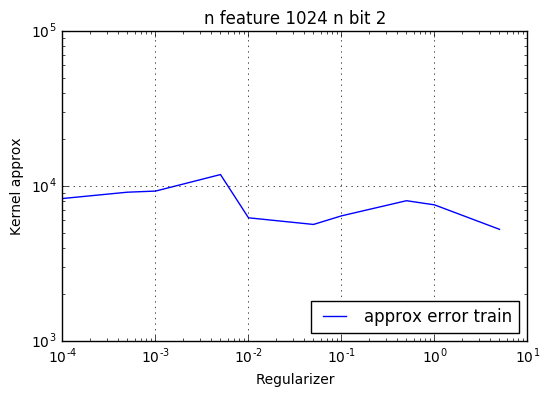

('using n feature / n bit', 4096, 2)


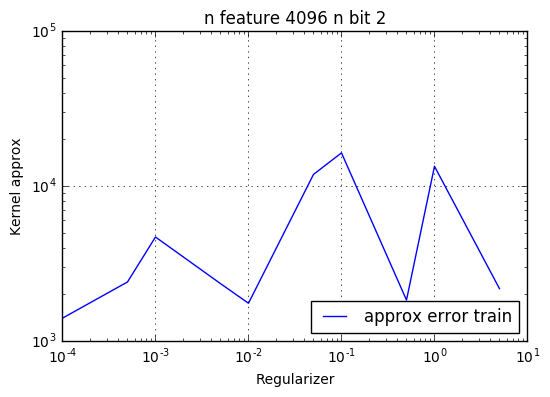

('using n feature / n bit', 16384, 2)


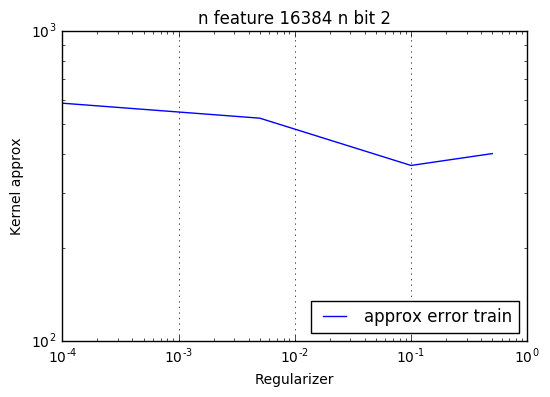

('using n feature / n bit', 65536, 2)
('using n feature / n bit', 262144, 2)
('using n feature / n bit', 1048576, 2)
('using n feature / n bit', 1024, 1)


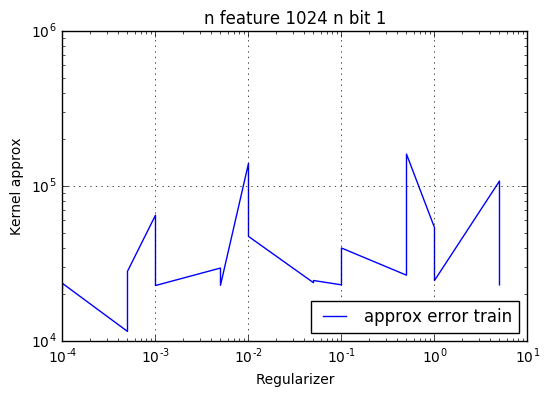

('using n feature / n bit', 4096, 1)


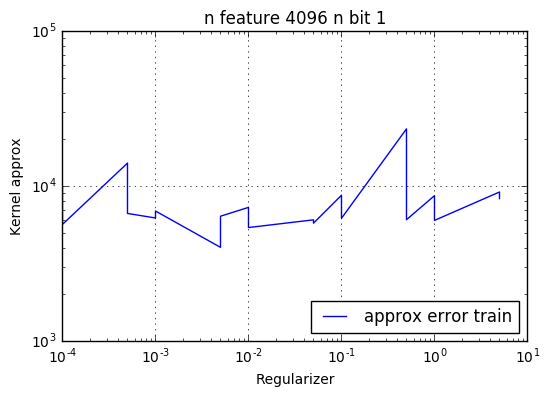

('using n feature / n bit', 16384, 1)


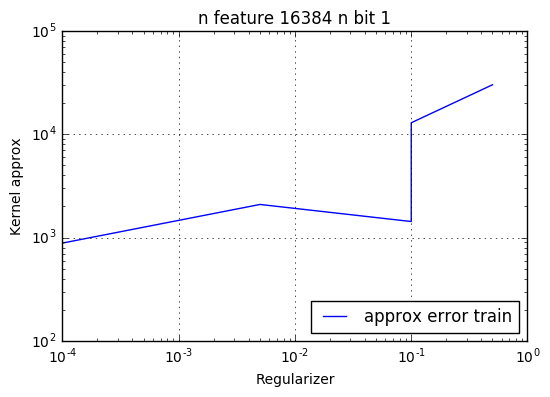

('using n feature / n bit', 65536, 1)
('using n feature / n bit', 262144, 1)
('using n feature / n bit', 1048576, 1)


In [49]:
def get_lp_rff_res(n_feat, n_bit):
    reg_lambda_list = []
    l2_error_train_list = []
    l2_error_test_list = []
    approx_error_train_list = []
    tmp_dict = []
    for key in dict_res.keys():
        if key.startswith("lp") and "n_fp_rff_" + str(n_feat) in key and "nbit_" + str(n_bit) in key:
            tmp_dict.append((key, dict_res[key] ) )
    tmp_dict = sorted(tmp_dict, key=lambda x: float(x[0].split("_lambda_")[1].split("_")[0] ))  
#     print tmp_dict
#     raw_input()
    for item in tmp_dict:
        reg_lambda = float(item[0].split("_lambda_")[1].split("_")[0] )
        reg_lambda_list.append(reg_lambda)
        l2_error_train_list.append(item[1]["train_l2_error"] )
        l2_error_test_list.append(item[1]["test_l2_error"] )
        approx_error_train_list.append(item[1]["train_approx_error"])
    return reg_lambda_list, l2_error_train_list, l2_error_test_list, approx_error_train_list

for n_bit in [16, 8, 4, 2, 1]:
    for n_feat in [1024, 4096, 16384, 65536, 262144, 1048576]:
        reg_lambda_list, l2_error_train_list, l2_error_test_list, approx_error_train_list = \
            get_lp_rff_res(n_feat, n_bit)
        print("using n feature / n bit", n_feat, n_bit)
        if len(reg_lambda_list) == 0:
            continue
#         plt.figure()
#         plt.loglog(reg_lambda_list, l2_error_train_list, label="l2 loss train")
#         plt.loglog(reg_lambda_list, l2_error_test_list, label="l2 loss test")
#         plt.xlabel("Regularizer")
#         plt.ylabel("L2 regression loss")
#         plt.title("n feature " + str(n_feat) + " n bit " + str(n_bit) )
#         plt.ylim([1e6, 1e8])
#         plt.grid()
#         plt.legend(loc="lower right")
#         plt.show()

#         plt.figure()
#         plt.loglog(reg_lambda_list, approx_error_train_list, label="approx error train")
#         plt.xlabel("Regularizer")
#         plt.ylabel("Kernel approx")
#         plt.title("n feature " + str(n_feat) + " n bit " + str(n_bit) )
#         plt.grid()
#         plt.legend(loc="lower right")
#         plt.show()

### plot fp kernel (of best regularizer) v.s. exact kernel (of best regularizer)